<a href="https://colab.research.google.com/github/molvcan/AN-SMART-RECYCLING-BIN-USING-WASTE-IMAGE-CLASSIFICATION-AT-THE-EDGE/blob/main/TrainingAndEvaludation_JetsonNanoModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Head**

Date : 01/24/2023<br />
Author : Xueying Li<br />
Description : This file is used to test and evaluate the model's accuracy<br />
Reference: I used part of code from https://github.com/mazabdul7/AtTheEdge/blob/main/Training.ipynb.<br /> 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!/opt/bin/nvidia-smi

Sat Jan 14 04:15:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!pip install tensorflow==2.11

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pathlib
from tensorflow.keras import layers
import random
import sys
from sklearn.metrics import confusion_matrix
sys.path.append('/content/drive/MyDrive')
sys.path.append('/content/drive/MyDrive/year3')
%cd /content/drive/MyDrive/year3

/content/drive/MyDrive/year3


In [ ]:
print(tf.__version__) # TF Version

2.9.2


In [ ]:
tf.random.set_seed(123)

## **Functions used for training the model**

In [ ]:
def loadTrainData(path,size=(384,512),crop=False):
  train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.25,
    subset="training",
    seed=123,
    image_size=size,
    batch_size=batch_size,crop_to_aspect_ratio=crop)

  val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.25,
    subset="validation",
    seed=123,
    image_size=size,
    batch_size=batch_size,crop_to_aspect_ratio=crop)
  AUTOTUNE = tf.data.AUTOTUNE
  train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
  return train_ds,val_ds
def createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,classNo,pretrain=False):
    # Don't use augumentation layer in tensorflow 2.9, it may show error (it will work in other versions of tensorflow)
    #Load EfficientNet base or MobileNet with weights pre-trained on ImageNet
    if modelStructure =="mobilenet":
        base_model =tf.keras.applications.MobileNetV3Large(input_shape=(basemodel_img_height, basemodel_img_width, 3),include_top=False,weights='imagenet')
    elif modelStructure =="mobilenetV1":
        base_model =tf.keras.applications.MobileNet(input_shape=(basemodel_img_height, basemodel_img_width, 3),alpha=0.75,include_top=False,weights='imagenet')
    elif modelStructure =="efficientnet":
        base_model = tf.keras.applications.EfficientNetB0(weights="imagenet",input_shape=(basemodel_img_height, basemodel_img_width, 3),include_top=False)
    # Unfreeze base model
    base_model.trainable = True
    # Create new model on top
    if not pretrain:
      inputs = tf.keras.Input(shape=(384, 512, 3))
    else:
      inputs = tf.keras.Input(shape=(112, 112, 3))
    # Apply random data augmentation
    # Resize layer to basemodel inputsize (only used in downscal=ling)
    
    data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"), #random hor flip
        layers.RandomFlip("vertical"), #random hor flip
        layers.RandomRotation(0.5), #random rotation up to 180deg
        layers.RandomZoom((0,-.75)), #up to 75% zoom
    ])

    if (basemodel_img_height,basemodel_img_width) != (384,512):
        x=data_augmentation(inputs)
        x=tf.keras.layers.Resizing(basemodel_img_width,basemodel_img_height)(x)
          
        x = base_model(x, training=False)
    else:
        x=data_augmentation(inputs)  
        x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    #There are seven class
    outputs = tf.keras.layers.Dense(classNo, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.summary()
    return model



def compileModel(model,learning_rate,epochs,train_ds,val_ds,optimizer='Adam'):
  callbacks = [keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir + modelCheckPointName, save_freq="epoch")]
  if optimizer=="Adam":
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),  # Low learning rate identified by lowest loss within the first 5 epochs
        loss="sparse_categorical_crossentropy" ,
        metrics=["accuracy"],)

  '''
  model_checkpoint_callback1 = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath1,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True,verbose=1)
  callbacks = []'''
  history=model.fit(train_ds, epochs=epochs, validation_data=val_ds)#callbacks=callbacks)
  return model,history

  #fit the model
#Import test set as images
def testAccuracy(model,testDataPath,image_size=(384,512)):
    wrongNo = 0
    correctLabel=[]
    predictedLabel = []
    wrongImage = []
    # load test set
    testImages = tf.keras.utils.image_dataset_from_directory(
        testDataPath,
        seed=123,
        image_size=image_size,
        batch_size=1)
    # iterate through all the test set and record rge mistakes made by the model
    for image, label in testImages:
        predictions = model.predict(image)
        predictedLabel.append(np.argmax(predictions[0]))
        correctLabel.append(label[0])
        # show the wrong image
        if np.argmax(predictions) != label[0]:
            wrongNo+=1
            wrongImage.append(image[0])
    print("The test accuracy is " + str((len(predictedLabel)-wrongNo)/len(predictedLabel)*100) + "%")
    confusionmatrix = confusion_matrix(correctLabel,predictedLabel)
    return confusionmatrix
#model.load_weights(r'12bestaccuracy.hdf5')

## **Pretaining** On HUAWEI Cloud dataset

In [ ]:
# Set variables for testing
# checkpoint weight to test
import os
modelCheckPointName="/pretrain"
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
modelStructure = "mobilenet" # or "efficientnet"
batch_size = 16
basemodel_img_height =224
basemodel_img_width = 224
learning_rate=4.3e-5

In [ ]:
train_ds,val_ds=loadTrainData("/content/content/drive/MyDrive/year3/Mydata",size=(112,112),crop=True)
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,159,pretrain=True)
epochs=5
model,history=compileModel(model,learning_rate,epochs,train_ds,val_ds)
model.save(checkpoint_dir+modelCheckPointName)

Found 54411 files belonging to 159 classes.
Using 40809 files for training.
Found 54411 files belonging to 159 classes.
Using 13602 files for validation.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 960)              0         
 (GlobalAveragePooling2D)            

In [ ]:
epochs=5
model,history=compileModel(model,learning_rate,epochs,train_ds,val_ds)

Epoch 1/5
2551/2551 [==============================] - 311s 120ms/step - loss: 0.9643 - accuracy: 0.7423 - val_loss: 0.9010 - val_accuracy: 0.7661
Epoch 2/5
2551/2551 [==============================] - 305s 120ms/step - loss: 0.8841 - accuracy: 0.7613 - val_loss: 0.8692 - val_accuracy: 0.7769
Epoch 3/5
2551/2551 [==============================] - 304s 119ms/step - loss: 0.8051 - accuracy: 0.7814 - val_loss: 0.8859 - val_accuracy: 0.7742
Epoch 4/5
2551/2551 [==============================] - 301s 118ms/step - loss: 0.7445 - accuracy: 0.7969 - val_loss: 0.8891 - val_accuracy: 0.7778
Epoch 5/5
2551/2551 [==============================] - 303s 119ms/step - loss: 0.6923 - accuracy: 0.8096 - val_loss: 0.8768 - val_accuracy: 0.7803


In [ ]:
epochs=5
model,history=compileModel(model,learning_rate,epochs,train_ds,val_ds)

Epoch 1/5
2551/2551 [==============================] - 310s 119ms/step - loss: 0.6470 - accuracy: 0.8210 - val_loss: 0.9080 - val_accuracy: 0.7828
Epoch 2/5
2551/2551 [==============================] - 302s 119ms/step - loss: 0.5993 - accuracy: 0.8323 - val_loss: 0.9284 - val_accuracy: 0.7828
Epoch 3/5
2551/2551 [==============================] - 302s 118ms/step - loss: 0.5490 - accuracy: 0.8449 - val_loss: 0.9276 - val_accuracy: 0.7858
Epoch 4/5
2551/2551 [==============================] - 303s 119ms/step - loss: 0.5179 - accuracy: 0.8540 - val_loss: 0.9802 - val_accuracy: 0.7794
Epoch 5/5
2551/2551 [==============================] - 304s 119ms/step - loss: 0.4854 - accuracy: 0.8635 - val_loss: 0.9710 - val_accuracy: 0.7830


In [ ]:
epochs=5
model,history=compileModel(model,learning_rate/2,epochs,train_ds,val_ds)

Epoch 1/5
2551/2551 [==============================] - 308s 119ms/step - loss: 0.3953 - accuracy: 0.8865 - val_loss: 0.9961 - val_accuracy: 0.7914
Epoch 2/5
2551/2551 [==============================] - 302s 119ms/step - loss: 0.3715 - accuracy: 0.8929 - val_loss: 1.0325 - val_accuracy: 0.7851
Epoch 3/5
2551/2551 [==============================] - 303s 119ms/step - loss: 0.3447 - accuracy: 0.9017 - val_loss: 1.0421 - val_accuracy: 0.7872
Epoch 4/5
2551/2551 [==============================] - 302s 118ms/step - loss: 0.3315 - accuracy: 0.9058 - val_loss: 1.0617 - val_accuracy: 0.7874
Epoch 5/5
2551/2551 [==============================] - 300s 118ms/step - loss: 0.3209 - accuracy: 0.9088 - val_loss: 1.0696 - val_accuracy: 0.7889


In [ ]:
model.save(checkpoint_dir+modelCheckPointName)

In [ ]:
# history
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']
print(str(acc)+",")
print(str(val_acc)+",")


[0.35095199942588806, 0.5795290470123291, 0.6480923295021057, 0.6912935972213745, 0.7186160087585449, 0.7422872185707092, 0.7612781524658203, 0.7813717722892761, 0.79693204164505, 0.8096498250961304, 0.8209953904151917, 0.8322674036026001, 0.844936192035675, 0.8539782762527466, 0.8635349869728088, 0.8864956498146057, 0.8929157853126526, 0.9016638398170471, 0.9058296084403992, 0.9088436365127563],
[0.5835171341896057, 0.6707102060317993, 0.7204822897911072, 0.7391560077667236, 0.7519482374191284, 0.7661373615264893, 0.7769445776939392, 0.7741508483886719, 0.7777532935142517, 0.7803264260292053, 0.7828260660171509, 0.7828260660171509, 0.7858403325080872, 0.7794442176818848, 0.7829731106758118, 0.791354238986969, 0.7851051092147827, 0.7871636748313904, 0.7873842120170593, 0.7888545989990234],


Text(0.5, 1.0, 'Training and Validation Accuracy')

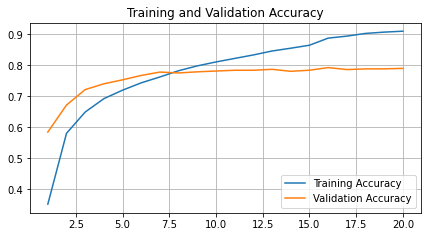

In [ ]:
# plot the trainig result
epochs_range = range(1,21)
plt.figure(figsize=(7, 3.5))


plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.grid(visible=True)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


In [ ]:
model1=model
from keras.models import Model

# Save and convert :


model2=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,159)
model2.set_weights(model1.get_weights())
x=model2.layers[-2].output
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)
model3 = tf.keras.Model(inputs=model2.input, outputs=outputs)

model3.summary()
model3.save(checkpoint_dir+modelCheckPointName+"mobilenet")

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 384, 512, 3)]     0         
                                                                 
 resizing_10 (Resizing)      (None, 224, 224, 3)       0         
                                                                 
 sequential_10 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_10  (None, 960)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 159)               152

## **Preprocessing**  :Load TrashNet and Xueying's dataset

In [ ]:
! unzip dataset-resized.zip
! unzip CollectedTraindata.zip

In [ ]:
import csv
with open("data.csv", 'r') as file:
  csvreader = csv.reader(file)
  dataSplit=[]
  for row in csvreader:
    dataSplit.append(row)
  dataSplit=dataSplit[1:]

In [ ]:
import os,shutil
categories = ["glass","metal","cardboard","paper","plastic"]
originalPath='dataset-resized/'
for i in range(5):
  TrashNetPath="TrashNet"+str(i)
  if os.path.exists(TrashNetPath):
    continue
  os.makedirs(TrashNetPath)
  os.makedirs(TrashNetPath+"/"+'test')
  os.makedirs(TrashNetPath+"/"+'train')
  for className in categories:
    os.makedirs(TrashNetPath+"/"+'train'+"/"+className)
    os.makedirs(TrashNetPath+"/"+'test'+"/"+className)
    for index in range(len(dataSplit)):
      if dataSplit[index][0]==className and dataSplit[index][2]!=str(i):
        shutil.copy(originalPath+className+"/"+dataSplit[index][1],TrashNetPath+"/"+'train'+"/"+className+"/"+dataSplit[index][1])
      elif dataSplit[index][0]==className and dataSplit[index][2]==str(i):
        shutil.copy(originalPath+className+"/"+dataSplit[index][1],TrashNetPath+"/"+'test'+"/"+className+"/"+dataSplit[index][1])
    

In [ ]:
import csv
with open("XL_hand_empty_split.csv", 'r') as file:
  csvreader = csv.reader(file)
  dataSplit=[]
  for row in csvreader:
    dataSplit.append(row)
  dataSplit=dataSplit[1:]

In [ ]:
import os,shutil
categories = ["hand","empty"]
originalPath='XueyingLi_TrashData/'
for i in range(5):
  TrashNetPath="XTrashNet"+str(i)
  for className in categories:
    os.makedirs(TrashNetPath+"/"+'train'+"/"+className)
    os.makedirs(TrashNetPath+"/"+'test'+"/"+className)
    for index in range(len(dataSplit)):
      if dataSplit[index][0]==className and dataSplit[index][2]!=str(i):
        shutil.copy(originalPath+className+"/"+dataSplit[index][1],TrashNetPath+"/"+'train'+"/"+className+"/"+dataSplit[index][1])
      elif dataSplit[index][0]==className and dataSplit[index][2]==str(i):
        shutil.copy(originalPath+className+"/"+dataSplit[index][1],TrashNetPath+"/"+'test'+"/"+className+"/"+dataSplit[index][1])

## **1.1**  :Train 5-class **EfficientNet** 384x512 using **TrashNet data** and 5-fold cross validation

In [ ]:
# Set variables for testing
# checkpoint weight to test
import os
modelCheckPointName="/ckpt"
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
modelStructure = "efficientnet" # or "efficientnet"
batch_size = 16
basemodel_img_height =384
basemodel_img_width = 512
learning_rate=4.3e-5
TrainingPath=''

### trial 1

In [ ]:
train_ds,val_ds=loadTrainData("TrashNet0/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,5)
epochs=50
model,history=compileModel(model,learning_rate,epochs,train_ds,val_ds)

Found 1912 files belonging to 5 classes.
Using 1434 files for training.
Found 1912 files belonging to 5 classes.
Using 478 files for validation.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 384, 512, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 12, 16, 1280)     4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                

In [ ]:
testAccuracy(model,"TrashNet0/test",image_size=(384,512))

Found 478 files belonging to 5 classes.
1/1 [==============================] - 0s 22ms/step
The test accuracy is 95.39748953974896%


array([[ 77,   0,   0,   4,   0],
       [  0,  96,   2,   0,   2],
       [  0,   3,  78,   0,   1],
       [  0,   1,   1, 115,   2],
       [  0,   2,   2,   2,  90]])

In [ ]:
# history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(str(acc)+",")
print(str(val_acc)+",")

loss = history.history['loss']
val_loss = history.history['val_loss']
print(str(loss)+",")

print(str(val_loss)+",")

[0.625523030757904, 0.8221757411956787, 0.8695955276489258, 0.9023709893226624, 0.9121338725090027, 0.9281729459762573, 0.9386332035064697, 0.9546722173690796, 0.9456067085266113, 0.9456067085266113, 0.9497907757759094, 0.9728033542633057, 0.9679219126701355, 0.9686192274093628, 0.9769874215126038, 0.982566237449646, 0.9783821702003479, 0.9818689227104187, 0.9839609265327454, 0.9769874215126038, 0.9804741740226746, 0.9776847958564758, 0.9769874215126038, 0.9867503643035889, 0.9902371168136597, 0.9867503643035889, 0.9839609265327454, 0.9888424277305603, 0.991631805896759, 0.9937238693237305, 0.9930264949798584, 0.9853556752204895, 0.9930264949798584, 0.9846583008766174, 0.991631805896759, 0.9888424277305603, 0.9895397424697876, 0.9902371168136597, 0.9923291206359863, 0.9874476790428162, 0.9853556752204895, 0.9972106218338013, 0.9818689227104187, 0.9937238693237305, 0.9923291206359863, 0.9972106218338013, 0.9930264949798584, 0.9930264949798584, 0.9958158731460571, 0.9951185584068298],
[0

Text(0.5, 1.0, 'Training and Validation Accuracy')

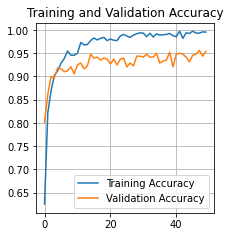

In [ ]:
# plot the trainig result
epochs_range = range(50)
plt.figure(figsize=(7, 3.5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.grid(visible=True)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

### trial 2

In [ ]:
train_ds,val_ds=loadTrainData("TrashNet1/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,5)
epochs=20
model,history=compileModel(model,learning_rate,epochs,train_ds,val_ds)

Found 1912 files belonging to 5 classes.
Using 1434 files for training.
Found 1912 files belonging to 5 classes.
Using 478 files for validation.
16705208/16705208 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 384, 512, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 12, 16, 1280)     4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)           

In [ ]:
epochs=30
model,history=compileModel(model,learning_rate,epochs,train_ds,val_ds)

Epoch 1/30
90/90 [==============================] - 76s 735ms/step - loss: 0.0496 - accuracy: 0.9819 - val_loss: 0.3240 - val_accuracy: 0.9226
Epoch 2/30
90/90 [==============================] - 64s 706ms/step - loss: 0.0714 - accuracy: 0.9777 - val_loss: 0.3891 - val_accuracy: 0.9100
Epoch 3/30
90/90 [==============================] - 65s 719ms/step - loss: 0.0593 - accuracy: 0.9784 - val_loss: 0.3798 - val_accuracy: 0.9059
Epoch 4/30
90/90 [==============================] - 65s 722ms/step - loss: 0.0398 - accuracy: 0.9847 - val_loss: 0.7649 - val_accuracy: 0.8787
Epoch 5/30
90/90 [==============================] - 64s 714ms/step - loss: 0.0561 - accuracy: 0.9791 - val_loss: 0.3890 - val_accuracy: 0.9142
Epoch 6/30
90/90 [==============================] - 65s 725ms/step - loss: 0.0628 - accuracy: 0.9770 - val_loss: 0.3059 - val_accuracy: 0.9205
Epoch 7/30
90/90 [==============================] - 65s 722ms/step - loss: 0.0423 - accuracy: 0.9868 - val_loss: 0.3243 - val_accuracy: 0.9247

In [ ]:
testAccuracy(model,"TrashNet1/test",image_size=(384,512))

Found 478 files belonging to 5 classes.
1/1 [==============================] - 0s 24ms/step
The test accuracy is 95.60669456066945%


array([[ 78,   0,   1,   2,   0],
       [  0,  92,   4,   0,   4],
       [  0,   0,  80,   0,   2],
       [  1,   0,   1, 116,   1],
       [  1,   3,   0,   1,  91]])

### trial 3

In [ ]:
train_ds,val_ds=loadTrainData("TrashNet2/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,5)
epochs=50
model,history=compileModel(model,learning_rate,epochs,train_ds,val_ds)

Found 1912 files belonging to 5 classes.
Using 1434 files for training.
Found 1912 files belonging to 5 classes.
Using 478 files for validation.
16705208/16705208 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 384, 512, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 12, 16, 1280)     4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)           

In [ ]:
testAccuracy(model,"TrashNet2/test",image_size=(384,512))

Found 478 files belonging to 5 classes.
1/1 [==============================] - 0s 34ms/step
The test accuracy is 96.44351464435147%


array([[ 79,   0,   0,   2,   0],
       [  0,  96,   2,   0,   2],
       [  0,   1,  81,   0,   0],
       [  5,   0,   1, 112,   1],
       [  0,   1,   1,   1,  93]])

### trial 4

In [ ]:
train_ds,val_ds=loadTrainData("TrashNet3/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,5)
epochs=50
model,history=compileModel(model,learning_rate,epochs,train_ds,val_ds)

Found 1912 files belonging to 5 classes.
Using 1434 files for training.
Found 1912 files belonging to 5 classes.
Using 478 files for validation.
16705208/16705208 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 384, 512, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 12, 16, 1280)     4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)           

In [ ]:
testAccuracy(model,"TrashNet3/test",image_size=(384,512))

Found 478 files belonging to 5 classes.
1/1 [==============================] - 0s 24ms/step
The test accuracy is 95.81589958158996%


array([[ 75,   0,   0,   5,   1],
       [  0,  95,   2,   0,   3],
       [  0,   1,  81,   0,   0],
       [  2,   0,   0, 116,   1],
       [  0,   2,   3,   0,  91]])

### trial 5

In [ ]:
train_ds,val_ds=loadTrainData("TrashNet4/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,5)
epochs=50
model,history=compileModel(model,learning_rate,epochs,train_ds,val_ds)

Found 1915 files belonging to 5 classes.
Using 1437 files for training.
Found 1915 files belonging to 5 classes.
Using 478 files for validation.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 384, 512, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 12, 16, 1280)     4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                

In [ ]:
testAccuracy(model,"TrashNet4/test",image_size=(384,512))

Found 475 files belonging to 5 classes.
1/1 [==============================] - 0s 34ms/step
The test accuracy is 93.47368421052632%


array([[ 76,   0,   0,   0,   3],
       [  0,  86,   2,   0,  12],
       [  0,   1,  77,   0,   4],
       [  1,   1,   2, 114,   0],
       [  0,   2,   2,   1,  91]])

## **1.2**  :Train 7-class **MobileNetV3** using **TrashNet data+ XueyingLi dataset** 224x224 and 5-fold cross validation

In [ ]:
# Set variables for testing
# checkpoint weight to test
import os,math
modelCheckPointName="/ckpt"
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
modelStructure = "mobilenet" # or "efficientnet"
batch_size = 16
basemodel_img_height =224
basemodel_img_width = 224
learning_rate=4.3e-5
TrainingPath=''

### No pretraining + learning rate 4.3e-5

In [ ]:
train_ds,val_ds=loadTrainData("XTrashNet0/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,7)
epochs=50

model,history=compileModel(model,learning_rate,epochs,train_ds,val_ds)


Found 3657 files belonging to 7 classes.
Using 2743 files for training.
Found 3657 files belonging to 7 classes.
Using 914 files for validation.
12683000/12683000 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)        

In [ ]:
# history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(str(acc)+",")
print(str(val_acc)+",")

loss = history.history['loss']
val_loss = history.history['val_loss']
print(str(loss)+",")

print(str(val_loss)+",")

[0.5308057069778442, 0.7342326045036316, 0.7998541593551636, 0.8268319368362427, 0.8512577414512634, 0.8672986030578613, 0.8742253184318542, 0.900473952293396, 0.9019321799278259, 0.9055778384208679, 0.923441469669342, 0.9281808137893677, 0.9263579845428467, 0.9383886456489563, 0.9413051605224609, 0.9420342445373535, 0.9478672742843628, 0.9449507594108582, 0.9537003040313721, 0.9595333337783813, 0.9588042497634888, 0.9591687917709351, 0.9566168189048767, 0.9551585912704468, 0.964637279510498, 0.9598979353904724, 0.967918336391449, 0.9682828783988953, 0.9668246507644653, 0.9704703092575073, 0.9682828783988953, 0.9690120220184326, 0.971563994884491, 0.9722931385040283, 0.9810426831245422, 0.96974116563797, 0.975209653377533, 0.9730222225189209, 0.9744805097579956, 0.9704703092575073, 0.9770324230194092, 0.9814072251319885, 0.9832300543785095, 0.9832300543785095, 0.9777615666389465, 0.9821363687515259, 0.9835945963859558, 0.9759387373924255, 0.9821363687515259, 0.9879693984985352],
[0.731

In [ ]:
testAccuracy(model,"XTrashNet0/test",image_size=(384,512))

Found 683 files belonging to 7 classes.
1/1 [==============================] - 0s 23ms/step
The test accuracy is 93.41142020497803%


array([[ 75,   0,   0,   0,   1,   5,   0],
       [  1,  20,   0,   0,   0,   0,   0],
       [  0,   0,  92,   0,   3,   1,   4],
       [  4,   0,   2, 173,   2,   3,   0],
       [  0,   0,   2,   0,  80,   0,   0],
       [  1,   0,   0,   0,   8, 110,   0],
       [  0,   0,   0,   0,   6,   2,  88]])

### No pretraining + learning rate 1e-5

In [ ]:
#train_ds,val_ds=loadTrainData("XTrashNet0/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,7)
epochs=50

model,history=compileModel(model,1e-5,epochs,train_ds,val_ds)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 resizing_2 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 7)                 6727

In [ ]:
# history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(str(acc)+",")
print(str(val_acc)+",")

loss = history.history['loss']
val_loss = history.history['val_loss']
print(str(loss)+",")

print(str(val_loss)+",")

[0.32300400733947754, 0.5519503951072693, 0.6675173044204712, 0.7156398296356201, 0.754283607006073, 0.7725118398666382, 0.7870944142341614, 0.8056871891021729, 0.8129785060882568, 0.8304775953292847, 0.832664966583252, 0.8348523378372192, 0.8512577414512634, 0.8501640558242798, 0.8662048578262329, 0.868392288684845, 0.8829748630523682, 0.8822457194328308, 0.8888078927993774, 0.895005464553833, 0.8975574374198914, 0.902296781539917, 0.9041195511817932, 0.9110463261604309, 0.9070360660552979, 0.9201604127883911, 0.9117754101753235, 0.9194312691688538, 0.9278162717819214, 0.9329201579093933, 0.9274516701698303, 0.9372949600219727, 0.9248997569084167, 0.930732786655426, 0.9332846999168396, 0.9394823312759399, 0.9427633881568909, 0.935836672782898, 0.9423988461494446, 0.9485964179039001, 0.9467735886573792, 0.9482318758964539, 0.9562522768974304, 0.9620853066444397, 0.9504192471504211, 0.9489610195159912, 0.9551585912704468, 0.9522420763969421, 0.9573459625244141, 0.9617207646369934],
[0.4

In [ ]:
testAccuracy(model,"XTrashNet0/test",image_size=(384,512))

Found 683 files belonging to 7 classes.
1/1 [==============================] - 0s 19ms/step
The test accuracy is 93.1185944363104%


array([[ 78,   0,   0,   0,   0,   3,   0],
       [  0,  21,   0,   0,   0,   0,   0],
       [  2,   0,  91,   0,   4,   0,   3],
       [  4,   0,   2, 174,   0,   3,   1],
       [  0,   0,   4,   0,  78,   0,   0],
       [  3,   0,   0,   0,   3, 113,   0],
       [  1,   0,   7,   0,   6,   1,  81]])

### No pretraining + learning rate schedule 

In [ ]:
#train_ds,val_ds=loadTrainData("XTrashNet0/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,7)
for i in range(5):
  epochs=10
  model,history=compileModel(model,4.3e-5/(math.pow(2, i)),epochs,train_ds,val_ds)
  if i==0:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
  else:
    acc += history.history['accuracy']
    val_acc += history.history['val_accuracy']
    loss += history.history['loss']
    val_loss += history.history['val_loss']

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 384, 512, 3)]     0         
                                                                 
 resizing_6 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 sequential_6 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_6   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 7)                 6727

In [ ]:
# history

print(str(acc)+",")
print(str(val_acc)+",")

print(str(loss)+",")

print(str(val_loss)+",")

[0.49106818437576294, 0.7232956886291504, 0.7852715849876404, 0.8093328475952148, 0.8494349122047424, 0.8607364296913147, 0.8756835460662842, 0.9030258655548096, 0.8975574374198914, 0.8993802666664124, 0.9176084399223328, 0.9183375835418701, 0.9409405589103699, 0.9362012147903442, 0.9402114748954773, 0.9416697025299072, 0.9453153610229492, 0.9478672742843628, 0.9478672742843628, 0.9515129327774048, 0.9555231332778931, 0.962449848651886, 0.9598979353904724, 0.9558877348899841, 0.9613561630249023, 0.960991621017456, 0.9650018215179443, 0.9657309651374817, 0.9701057076454163, 0.9722931385040283, 0.9675537943840027, 0.975209653377533, 0.9675537943840027, 0.9744805097579956, 0.9737513661384583, 0.9784907102584839, 0.9730222225189209, 0.9773970246315002, 0.9766678810119629, 0.9806780815124512, 0.9795843958854675, 0.9799489378929138, 0.9755741953849792, 0.9777615666389465, 0.9828654527664185, 0.9722931385040283, 0.9810426831245422, 0.9799489378929138, 0.9792198538780212, 0.9821363687515259],


In [ ]:
testAccuracy(model,"XTrashNet0/test",image_size=(384,512))

Found 683 files belonging to 7 classes.
1/1 [==============================] - 0s 20ms/step
The test accuracy is 93.99707174231332%


array([[ 76,   0,   0,   0,   1,   4,   0],
       [  0,  21,   0,   0,   0,   0,   0],
       [  0,   0,  91,   0,   4,   0,   5],
       [  4,   0,   2, 174,   1,   2,   1],
       [  0,   0,   2,   0,  79,   0,   1],
       [  0,   0,   0,   1,   5, 113,   0],
       [  0,   0,   4,   0,   2,   2,  88]])

### No pretraining + learning rate schedule +384x512 model

In [ ]:
train_ds,val_ds=loadTrainData("XTrashNet0/train",size=(384,512))
model=createModel("mobilenet" ,384,512,16,7)
for i in range(5):
  epochs=10
  model,history=compileModel(model,4.3e-5/(math.pow(2, i)),epochs,train_ds,val_ds)
  if i==0:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
  else:
    acc += history.history['accuracy']
    val_acc += history.history['val_accuracy']
    loss += history.history['loss']
    val_loss += history.history['val_loss']

Found 3657 files belonging to 7 classes.
Using 2743 files for training.


Found 3657 files belonging to 7 classes.
Using 914 files for validation.
12683000/12683000 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 384, 512, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 12, 16, 960)      2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 7)                 

In [ ]:
# history

print(str(acc)+",")
print(str(val_acc)+",")

print(str(loss)+",")

print(str(val_loss)+",")

[0.5752825140953064, 0.7674079537391663, 0.8115202188491821, 0.8505285978317261, 0.8585490584373474, 0.8833394050598145, 0.8902661204338074, 0.9063069820404053, 0.9095880389213562, 0.9179730415344238, 0.9387531876564026, 0.9372949600219727, 0.9362012147903442, 0.9485964179039001, 0.9493255615234375, 0.9493255615234375, 0.9547940492630005, 0.9602624773979187, 0.9500547051429749, 0.9573459625244141, 0.9617207646369934, 0.9701057076454163, 0.9682828783988953, 0.9657309651374817, 0.967918336391449, 0.9693766236305237, 0.9708348512649536, 0.96974116563797, 0.9690120220184326, 0.9719285368919373, 0.9755741953849792, 0.9737513661384583, 0.9770324230194092, 0.9737513661384583, 0.9806780815124512, 0.9766678810119629, 0.975209653377533, 0.9763033390045166, 0.9788552522659302, 0.9792198538780212, 0.9821363687515259, 0.9832300543785095, 0.9835945963859558, 0.9817717671394348, 0.9854174256324768, 0.9792198538780212, 0.9803135395050049, 0.9839591979980469, 0.9857819676399231, 0.9839591979980469],
[0

In [ ]:
testAccuracy(model,"XTrashNet0/test",image_size=(384,512))

Found 683 files belonging to 7 classes.
1/1 [==============================] - 0s 22ms/step
The test accuracy is 94.28989751098096%


array([[ 76,   0,   0,   0,   0,   5,   0],
       [  0,  21,   0,   0,   0,   0,   0],
       [  0,   0,  95,   0,   4,   0,   1],
       [  5,   0,   0, 178,   0,   1,   0],
       [  0,   0,   3,   0,  78,   0,   1],
       [  4,   0,   0,   0,   1, 114,   0],
       [  1,   0,   4,   0,   7,   2,  82]])

### Use pretraining + learning rate 4.3e-5

In [ ]:
#train_ds,val_ds=loadTrainData("XTrashNet0/train",size=(384,512))
model = tf.keras.models.load_model('ckpt/pretrainmobilenet')
epochs=10

model,history=compileModel(model,learning_rate,epochs,train_ds,val_ds)

Epoch 1/10
172/172 [==============================] - 29s 138ms/step - loss: 1.5420 - accuracy: 0.5337 - val_loss: 0.7619 - val_accuracy: 0.7254
Epoch 2/10
172/172 [==============================] - 23s 133ms/step - loss: 0.7410 - accuracy: 0.7328 - val_loss: 0.5217 - val_accuracy: 0.8217
Epoch 3/10
172/172 [==============================] - 22s 130ms/step - loss: 0.5583 - accuracy: 0.8031 - val_loss: 0.4630 - val_accuracy: 0.8359
Epoch 4/10
172/172 [==============================] - 23s 132ms/step - loss: 0.4721 - accuracy: 0.8341 - val_loss: 0.3947 - val_accuracy: 0.8632
Epoch 5/10
172/172 [==============================] - 22s 130ms/step - loss: 0.4033 - accuracy: 0.8662 - val_loss: 0.3680 - val_accuracy: 0.8742
Epoch 6/10
172/172 [==============================] - 22s 130ms/step - loss: 0.3497 - accuracy: 0.8815 - val_loss: 0.3657 - val_accuracy: 0.8851
Epoch 7/10
172/172 [==============================] - 23s 132ms/step - loss: 0.2870 - accuracy: 0.8972 - val_loss: 0.3432 - val_ac

In [ ]:
epochs=40

model,history=compileModel(model,learning_rate,epochs,train_ds,val_ds)

Epoch 1/40
172/172 [==============================] - 29s 136ms/step - loss: 0.2056 - accuracy: 0.9307 - val_loss: 0.3899 - val_accuracy: 0.8895
Epoch 2/40
172/172 [==============================] - 23s 131ms/step - loss: 0.1795 - accuracy: 0.9413 - val_loss: 0.3635 - val_accuracy: 0.8961
Epoch 3/40
172/172 [==============================] - 22s 130ms/step - loss: 0.1694 - accuracy: 0.9388 - val_loss: 0.3788 - val_accuracy: 0.8939
Epoch 4/40
172/172 [==============================] - 22s 130ms/step - loss: 0.1526 - accuracy: 0.9453 - val_loss: 0.4082 - val_accuracy: 0.8851
Epoch 5/40
172/172 [==============================] - 22s 130ms/step - loss: 0.1397 - accuracy: 0.9504 - val_loss: 0.4024 - val_accuracy: 0.8950
Epoch 6/40
172/172 [==============================] - 23s 134ms/step - loss: 0.1216 - accuracy: 0.9577 - val_loss: 0.3609 - val_accuracy: 0.9048
Epoch 7/40
172/172 [==============================] - 23s 132ms/step - loss: 0.1292 - accuracy: 0.9559 - val_loss: 0.3805 - val_ac

In [ ]:
# history
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']
print(str(acc)+",")
print(str(val_acc)+",")

loss += history.history['loss']
val_loss += history.history['val_loss']
print(str(loss)+",")

print(str(val_loss)+",")

[0.5337222218513489, 0.7327743172645569, 0.8031352758407593, 0.8341231942176819, 0.8662048578262329, 0.8815165758132935, 0.8971928358078003, 0.8993802666664124, 0.9259934425354004, 0.9300036430358887, 0.930732786655426, 0.9413051605224609, 0.9387531876564026, 0.9453153610229492, 0.9504192471504211, 0.9577105641365051, 0.9558877348899841, 0.9617207646369934, 0.9620853066444397, 0.9693766236305237, 0.9653663635253906, 0.9682828783988953, 0.9671891927719116, 0.9744805097579956, 0.9617207646369934, 0.9730222225189209, 0.9744805097579956, 0.9741159081459045, 0.9730222225189209, 0.9755741953849792, 0.9810426831245422, 0.9755741953849792, 0.9741159081459045, 0.9766678810119629, 0.9759387373924255, 0.9770324230194092, 0.9795843958854675, 0.9788552522659302, 0.9828654527664185, 0.9857819676399231, 0.9835945963859558, 0.9850528836250305, 0.9843237400054932, 0.9857819676399231, 0.9744805097579956, 0.9766678810119629, 0.9872402548789978, 0.9861465692520142, 0.9821363687515259, 0.9857819676399231],

In [ ]:
testAccuracy(model,"XTrashNet0/test",image_size=(384,512))

Found 683 files belonging to 7 classes.
1/1 [==============================] - 0s 21ms/step
The test accuracy is 90.04392386530014%


array([[ 74,   0,   0,   0,   0,   7,   0],
       [  0,  21,   0,   0,   0,   0,   0],
       [  0,   0,  88,   0,   6,   1,   5],
       [  5,   0,   0, 170,   0,   3,   6],
       [  0,   0,   2,   0,  80,   0,   0],
       [  1,   0,   1,   0,   1, 115,   1],
       [  1,   0,  11,   0,   9,   8,  67]])

### Use pretraining + learning rate 1e-5

In [ ]:
#train_ds,val_ds=loadTrainData("XTrashNet0/train",size=(384,512))
model = tf.keras.models.load_model('ckpt/pretrainmobilenet')
epochs=50

model,history=compileModel(model,1e-5,epochs,train_ds,val_ds)

Epoch 1/50
172/172 [==============================] - 29s 136ms/step - loss: 2.7163 - accuracy: 0.3361 - val_loss: 1.6878 - val_accuracy: 0.4650
Epoch 2/50
172/172 [==============================] - 23s 132ms/step - loss: 1.4079 - accuracy: 0.5242 - val_loss: 1.1285 - val_accuracy: 0.6083
Epoch 3/50
172/172 [==============================] - 23s 133ms/step - loss: 1.0582 - accuracy: 0.6216 - val_loss: 0.8897 - val_accuracy: 0.6827
Epoch 4/50
172/172 [==============================] - 23s 133ms/step - loss: 0.8756 - accuracy: 0.6836 - val_loss: 0.7515 - val_accuracy: 0.7363
Epoch 5/50
172/172 [==============================] - 23s 133ms/step - loss: 0.7707 - accuracy: 0.7310 - val_loss: 0.6599 - val_accuracy: 0.7681
Epoch 6/50
172/172 [==============================] - 23s 133ms/step - loss: 0.6868 - accuracy: 0.7619 - val_loss: 0.6096 - val_accuracy: 0.7877
Epoch 7/50
172/172 [==============================] - 23s 133ms/step - loss: 0.6392 - accuracy: 0.7820 - val_loss: 0.5682 - val_ac

In [ ]:
# history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(str(acc)+",")
print(str(val_acc)+",")

loss= history.history['loss']
val_loss = history.history['val_loss']
print(str(loss)+",")

print(str(val_loss)+",")

[0.3361283242702484, 0.5242435336112976, 0.6215822100639343, 0.6835581660270691, 0.7309514880180359, 0.7619394659996033, 0.7819905281066895, 0.8049580454826355, 0.8209989070892334, 0.82901930809021, 0.8432373404502869, 0.8501640558242798, 0.8570907711982727, 0.8603718280792236, 0.8786000609397888, 0.8822457194328308, 0.8869850635528564, 0.8982865214347839, 0.9070360660552979, 0.9015676379203796, 0.9139628410339355, 0.9150565266609192, 0.9128690958023071, 0.9274516701698303, 0.9332846999168396, 0.9329201579093933, 0.9380240440368652, 0.9402114748954773, 0.9453153610229492, 0.9416697025299072, 0.9416697025299072, 0.9445862174034119, 0.9507837891578674, 0.9569814205169678, 0.9573459625244141, 0.9566168189048767, 0.9558877348899841, 0.9617207646369934, 0.9555231332778931, 0.9591687917709351, 0.9602624773979187, 0.9617207646369934, 0.975209653377533, 0.9671891927719116, 0.9722931385040283, 0.9704703092575073, 0.9744805097579956, 0.9701057076454163, 0.9737513661384583, 0.9719285368919373],
[

In [ ]:
testAccuracy(model,"XTrashNet0/test",image_size=(384,512))

Found 683 files belonging to 7 classes.
1/1 [==============================] - 0s 21ms/step
The test accuracy is 90.04392386530014%


array([[ 74,   0,   0,   0,   0,   7,   0],
       [  0,  21,   0,   0,   0,   0,   0],
       [  0,   0,  88,   0,   6,   1,   5],
       [  5,   0,   0, 170,   0,   3,   6],
       [  0,   0,   2,   0,  80,   0,   0],
       [  1,   0,   1,   0,   1, 115,   1],
       [  1,   0,  11,   0,   9,   8,  67]])

### Trial 2


In [ ]:
train_ds,val_ds=loadTrainData("XTrashNet1/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,7)
for i in range(5):
  epochs=10
  model,history=compileModel(model,4.3e-5/(math.pow(2, i)),epochs,train_ds,val_ds)
  if i==0:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
  else:
    acc += history.history['accuracy']
    val_acc += history.history['val_accuracy']
    loss += history.history['loss']
    val_loss += history.history['val_loss']

Found 3657 files belonging to 7 classes.
Using 2743 files for training.
Found 3657 files belonging to 7 classes.
Using 914 files for validation.
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 384, 512, 3)]     0         
                                                                 
 resizing_7 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 sequential_7 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_7   (None, 960)              0         
 (GlobalAveragePooling2D)                     

172/172 [==============================] - 31s 146ms/step - loss: 0.1218 - accuracy: 0.9588 - val_loss: 0.3192 - val_accuracy: 0.9201
Epoch 2/10
172/172 [==============================] - 23s 133ms/step - loss: 0.1179 - accuracy: 0.9610 - val_loss: 0.3121 - val_accuracy: 0.9212
Epoch 3/10
172/172 [==============================] - 23s 132ms/step - loss: 0.1097 - accuracy: 0.9643 - val_loss: 0.3386 - val_accuracy: 0.9201
Epoch 4/10
172/172 [==============================] - 23s 132ms/step - loss: 0.0997 - accuracy: 0.9635 - val_loss: 0.3266 - val_accuracy: 0.9223
Epoch 5/10
172/172 [==============================] - 23s 133ms/step - loss: 0.0907 - accuracy: 0.9745 - val_loss: 0.3325 - val_accuracy: 0.9147
Epoch 6/10
172/172 [==============================] - 23s 133ms/step - loss: 0.1034 - accuracy: 0.9650 - val_loss: 0.3179 - val_accuracy: 0.9190
Epoch 7/10
172/172 [==============================] - 23s 133ms/step - loss: 0.0979 - accuracy: 0.9657 - val_loss: 0.3363 - val_accuracy: 0.9

In [ ]:
# history

print(str(acc)+",")
print(str(val_acc)+",")

print(str(loss)+",")

print(str(val_loss)+",")

[0.5388261079788208, 0.7458986639976501, 0.8013124465942383, 0.8282901644706726, 0.8625592589378357, 0.8603718280792236, 0.8844330906867981, 0.8997448086738586, 0.9059423804283142, 0.9143273830413818, 0.9285454154014587, 0.9329201579093933, 0.9391177296638489, 0.9475027322769165, 0.9460445046424866, 0.9467735886573792, 0.9485964179039001, 0.9489610195159912, 0.9566168189048767, 0.9485964179039001, 0.9588042497634888, 0.960991621017456, 0.964272677898407, 0.9635435938835144, 0.9744805097579956, 0.9650018215179443, 0.9657309651374817, 0.9726576805114746, 0.9693766236305237, 0.9759387373924255, 0.9814072251319885, 0.975209653377533, 0.9825009107589722, 0.9814072251319885, 0.9730222225189209, 0.9766678810119629, 0.9817717671394348, 0.975209653377533, 0.9788552522659302, 0.9803135395050049, 0.9781261682510376, 0.9795843958854675, 0.9850528836250305, 0.9795843958854675, 0.9828654527664185, 0.9832300543785095, 0.9803135395050049, 0.9792198538780212, 0.9832300543785095, 0.9817717671394348],
[0

In [ ]:
testAccuracy(model,"XTrashNet1/test",image_size=(384,512))

Found 683 files belonging to 7 classes.
1/1 [==============================] - 0s 26ms/step
The test accuracy is 94.43631039531479%


array([[ 75,   0,   0,   0,   1,   5,   0],
       [  1,  18,   2,   0,   0,   0,   0],
       [  0,   0,  93,   0,   5,   1,   1],
       [  1,   0,   0, 179,   1,   1,   2],
       [  0,   0,   1,   0,  81,   0,   0],
       [  5,   0,   1,   0,   1, 112,   0],
       [  0,   0,   6,   0,   2,   1,  87]])

### Trial 3


In [ ]:
train_ds,val_ds=loadTrainData("XTrashNet2/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,7)
for i in range(5):
  epochs=10
  model,history=compileModel(model,4.3e-5/(math.pow(2, i)),epochs,train_ds,val_ds)
  if i==0:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
  else:
    acc += history.history['accuracy']
    val_acc += history.history['val_accuracy']
    loss += history.history['loss']
    val_loss += history.history['val_loss']

Found 3657 files belonging to 7 classes.
Using 2743 files for training.
Found 3657 files belonging to 7 classes.
Using 914 files for validation.
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 384, 512, 3)]     0         
                                                                 
 resizing_8 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 sequential_8 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_8   (None, 960)              0         
 (GlobalAveragePooling2D)                     

In [ ]:
# history

print(str(acc)+",")
print(str(val_acc)+",")

print(str(loss)+",")

print(str(val_loss)+",")

[0.5596062541007996, 0.7491797208786011, 0.7940211296081543, 0.8169887065887451, 0.8490703701972961, 0.868392288684845, 0.8815165758132935, 0.88953697681427, 0.9030258655548096, 0.9081298112869263, 0.930368185043335, 0.9332846999168396, 0.9354721307754517, 0.9365658164024353, 0.9544294476509094, 0.9398468732833862, 0.9533357620239258, 0.9489610195159912, 0.9547940492630005, 0.9551585912704468, 0.9584396481513977, 0.960991621017456, 0.9675537943840027, 0.962449848651886, 0.9682828783988953, 0.9668246507644653, 0.962814450263977, 0.9701057076454163, 0.9719285368919373, 0.9668246507644653, 0.9755741953849792, 0.9726576805114746, 0.9770324230194092, 0.975209653377533, 0.973386824131012, 0.9817717671394348, 0.975209653377533, 0.9741159081459045, 0.9773970246315002, 0.9741159081459045, 0.9799489378929138, 0.9759387373924255, 0.9803135395050049, 0.975209653377533, 0.9799489378929138, 0.9814072251319885, 0.9814072251319885, 0.9814072251319885, 0.9784907102584839, 0.9821363687515259],
[0.757111

In [ ]:
testAccuracy(model,"XTrashNet2/test",image_size=(384,512))

Found 683 files belonging to 7 classes.
1/1 [==============================] - 0s 26ms/step
The test accuracy is 93.85065885797951%


array([[ 76,   0,   0,   0,   0,   5,   0],
       [  4,  17,   0,   0,   0,   0,   0],
       [  0,   0,  95,   0,   4,   1,   0],
       [  1,   0,   0, 181,   0,   2,   0],
       [  0,   0,   1,   0,  81,   0,   0],
       [  6,   0,   1,   0,   3, 107,   2],
       [  1,   0,   5,   0,   4,   2,  84]])

### Trial 4


In [ ]:
train_ds,val_ds=loadTrainData("XTrashNet3/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,7)
for i in range(5):
  epochs=10
  model,history=compileModel(model,4.3e-5/(math.pow(2, i)),epochs,train_ds,val_ds)
  if i==0:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
  else:
    acc += history.history['accuracy']
    val_acc += history.history['val_accuracy']
    loss += history.history['loss']
    val_loss += history.history['val_loss']

Found 3657 files belonging to 7 classes.
Using 2743 files for training.
Found 3657 files belonging to 7 classes.
Using 914 files for validation.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 384, 512, 3)       0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 960)              0         
 (GlobalAveragePooling2D)                     

In [ ]:
# history

print(str(acc)+",")
print(str(val_acc)+",")

print(str(loss)+",")

print(str(val_loss)+",")

[0.5351804494857788, 0.7524608373641968, 0.8268319368362427, 0.8570907711982727, 0.8829748630523682, 0.8847976922988892, 0.9008384943008423, 0.9063069820404053, 0.9143273830413818, 0.9230769276618958, 0.9442216753959656, 0.9427633881568909, 0.9467735886573792, 0.9533357620239258, 0.9511483907699585, 0.9515129327774048, 0.9617207646369934, 0.9566168189048767, 0.9613561630249023, 0.962814450263977, 0.9617207646369934, 0.9635435938835144, 0.975209653377533, 0.9722931385040283, 0.9781261682510376, 0.9704703092575073, 0.9737513661384583, 0.9708348512649536, 0.9788552522659302, 0.9817717671394348, 0.9777615666389465, 0.9795843958854675, 0.9828654527664185, 0.9795843958854675, 0.9825009107589722, 0.9817717671394348, 0.9781261682510376, 0.9821363687515259, 0.9748450517654419, 0.9817717671394348, 0.9803135395050049, 0.9832300543785095, 0.9861465692520142, 0.9850528836250305, 0.9832300543785095, 0.9806780815124512, 0.9817717671394348, 0.9854174256324768, 0.9828654527664185, 0.9857819676399231],


In [ ]:
testAccuracy(model,"XTrashNet3/test",image_size=(384,512))

Found 683 files belonging to 7 classes.
1/1 [==============================] - 0s 20ms/step
The test accuracy is 95.02196193265007%


array([[ 73,   0,   0,   0,   0,   8,   0],
       [  1,  20,   0,   0,   0,   0,   0],
       [  0,   0,  94,   0,   1,   0,   5],
       [  1,   0,   1, 176,   3,   0,   3],
       [  1,   0,   0,   0,  80,   0,   1],
       [  2,   0,   0,   0,   0, 117,   0],
       [  0,   0,   3,   0,   4,   0,  89]])

### Trial 5


In [ ]:
train_ds,val_ds=loadTrainData("XTrashNet4/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,7)
for i in range(5):
  epochs=10
  model,history=compileModel(model,4.3e-5/(math.pow(2, i)),epochs,train_ds,val_ds)
  if i==0:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
  else:
    acc += history.history['accuracy']
    val_acc += history.history['val_accuracy']
    loss += history.history['loss']
    val_loss += history.history['val_loss']

Found 3662 files belonging to 7 classes.
Using 2747 files for training.
Found 3662 files belonging to 7 classes.
Using 915 files for validation.
12683000/12683000 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 384, 512, 3)       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)        

In [ ]:
# history

print(str(acc)+",")
print(str(val_acc)+",")

print(str(loss)+",")

print(str(val_loss)+",")

[0.5205678939819336, 0.7455406188964844, 0.8099744915962219, 0.8380051255226135, 0.8696759939193726, 0.8780487775802612, 0.8813250660896301, 0.9086275696754456, 0.9170003533363342, 0.9104477763175964, 0.9377502799034119, 0.939570426940918, 0.9413906335830688, 0.9443028569221497, 0.9501274228096008, 0.9570440649986267, 0.9541317820549011, 0.961048424243927, 0.9526756405830383, 0.9592282772064209, 0.9676010012626648, 0.9668729305267334, 0.9712413549423218, 0.9672369956970215, 0.9726974964141846, 0.9650527834892273, 0.9716053605079651, 0.9748817086219788, 0.9767018556594849, 0.9726974964141846, 0.973425567150116, 0.9763378500938416, 0.9770658612251282, 0.9792500734329224, 0.9781579971313477, 0.9799781441688538, 0.9799781441688538, 0.9854386448860168, 0.9774299263954163, 0.9847105741500854, 0.982526421546936, 0.9799781441688538, 0.982526421546936, 0.9803422093391418, 0.9817983508110046, 0.9836184978485107, 0.9828904271125793, 0.9803422093391418, 0.9854386448860168, 0.9850746393203735],
[0.

In [ ]:
testAccuracy(model,"XTrashNet4/test",image_size=(384,512))

Found 678 files belonging to 7 classes.
1/1 [==============================] - 0s 20ms/step
The test accuracy is 92.62536873156341%


array([[ 77,   0,   0,   0,   0,   1,   1],
       [  1,  19,   0,   0,   0,   0,   0],
       [  0,   0,  84,   0,   7,   0,   9],
       [  4,   0,   1, 173,   3,   1,   1],
       [  0,   0,   1,   0,  78,   0,   3],
       [  2,   0,   0,   0,   4, 110,   2],
       [  1,   0,   6,   0,   2,   0,  87]])

In [ ]:
from google. colab import runtime 
runtime.unassign()

### Compare

6
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


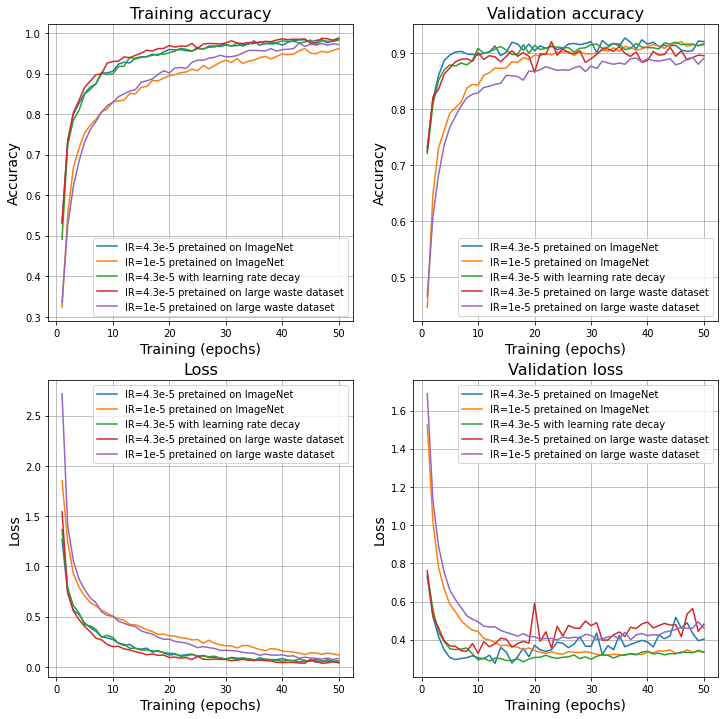

In [ ]:
# B1 data
# no preprocessing
import matplotlib.pyplot as plt
import numpy as np
trial=[[[0.5308057069778442, 0.7342326045036316, 0.7998541593551636, 0.8268319368362427, 0.8512577414512634, 0.8672986030578613, 0.8742253184318542, 0.900473952293396, 0.9019321799278259, 0.9055778384208679, 0.923441469669342, 0.9281808137893677, 0.9263579845428467, 0.9383886456489563, 0.9413051605224609, 0.9420342445373535, 0.9478672742843628, 0.9449507594108582, 0.9537003040313721, 0.9595333337783813, 0.9588042497634888, 0.9591687917709351, 0.9566168189048767, 0.9551585912704468, 0.964637279510498, 0.9598979353904724, 0.967918336391449, 0.9682828783988953, 0.9668246507644653, 0.9704703092575073, 0.9682828783988953, 0.9690120220184326, 0.971563994884491, 0.9722931385040283, 0.9810426831245422, 0.96974116563797, 0.975209653377533, 0.9730222225189209, 0.9744805097579956, 0.9704703092575073, 0.9770324230194092, 0.9814072251319885, 0.9832300543785095, 0.9832300543785095, 0.9777615666389465, 0.9821363687515259, 0.9835945963859558, 0.9759387373924255, 0.9821363687515259, 0.9879693984985352],
[0.7319474816322327, 0.8172866702079773, 0.8610503077507019, 0.8873085379600525, 0.8971553444862366, 0.9026257991790771, 0.9037199020385742, 0.8993435502052307, 0.8982494473457336, 0.8971553444862366, 0.9004376530647278, 0.9026257991790771, 0.9135667681694031, 0.8960612416267395, 0.9026257991790771, 0.920131266117096, 0.9168490171432495, 0.9059081077575684, 0.9168490171432495, 0.9048140048980713, 0.9135667681694031, 0.9091903567314148, 0.9135667681694031, 0.9070022106170654, 0.9091903567314148, 0.9168490171432495, 0.9179431200027466, 0.9157549142837524, 0.9179431200027466, 0.921225368976593, 0.9015317559242249, 0.9234135746955872, 0.9146608114242554, 0.9179431200027466, 0.9135667681694031, 0.9277899265289307, 0.920131266117096, 0.9080962538719177, 0.9245076775550842, 0.9168490171432495, 0.920131266117096, 0.912472665309906, 0.9146608114242554, 0.9135667681694031, 0.9146608114242554, 0.9059081077575684, 0.9037199020385742, 0.9048140048980713, 0.9223194718360901, 0.921225368976593],
[1.2675467729568481, 0.7379297018051147, 0.5641055703163147, 0.5225405693054199, 0.43644505739212036, 0.3919321596622467, 0.354557603597641, 0.30012744665145874, 0.2899388074874878, 0.2731691002845764, 0.23650650680065155, 0.21402999758720398, 0.22480712831020355, 0.185448557138443, 0.17765533924102783, 0.18734057247638702, 0.14697368443012238, 0.16288703680038452, 0.14011211693286896, 0.11986880004405975, 0.1255819946527481, 0.11466888338327408, 0.12191316485404968, 0.12927114963531494, 0.10187811404466629, 0.11550242453813553, 0.09748733043670654, 0.09709004312753677, 0.08884403109550476, 0.07993576675653458, 0.09551899880170822, 0.08738812059164047, 0.0881832093000412, 0.08063854277133942, 0.06097111105918884, 0.09272980690002441, 0.0726303905248642, 0.07454334199428558, 0.07287073135375977, 0.08375241607427597, 0.06812892109155655, 0.06246499344706535, 0.05083712190389633, 0.057106517255306244, 0.06810766458511353, 0.04786866158246994, 0.04958517476916313, 0.07374530285596848, 0.05514885112643242, 0.04039117321372032],
[0.7291554808616638, 0.5224907994270325, 0.41599178314208984, 0.3471986949443817, 0.3062607944011688, 0.2963947355747223, 0.3019818663597107, 0.30636048316955566, 0.316471666097641, 0.3055106997489929, 0.30073463916778564, 0.3191344141960144, 0.2767238914966583, 0.3603213131427765, 0.3351067900657654, 0.27829745411872864, 0.310835599899292, 0.35597923398017883, 0.3109223246574402, 0.3708781599998474, 0.34716469049453735, 0.3388845920562744, 0.3483531177043915, 0.38759928941726685, 0.38169923424720764, 0.3586667478084564, 0.37774327397346497, 0.4154256284236908, 0.3668615221977234, 0.3649563193321228, 0.43508392572402954, 0.32277610898017883, 0.3692530393600464, 0.34821757674217224, 0.42296382784843445, 0.36344030499458313, 0.3756399154663086, 0.38654831051826477, 0.39708247780799866, 0.38841384649276733, 0.36238229274749756, 0.4249899089336395, 0.40528419613838196, 0.4201529920101166, 0.517490029335022, 0.45993050932884216, 0.4895991384983063, 0.43335404992103577, 0.3950967490673065, 0.40318530797958374],]]
trial.append([[0.32300400733947754, 0.5519503951072693, 0.6675173044204712, 0.7156398296356201, 0.754283607006073, 0.7725118398666382, 0.7870944142341614, 0.8056871891021729, 0.8129785060882568, 0.8304775953292847, 0.832664966583252, 0.8348523378372192, 0.8512577414512634, 0.8501640558242798, 0.8662048578262329, 0.868392288684845, 0.8829748630523682, 0.8822457194328308, 0.8888078927993774, 0.895005464553833, 0.8975574374198914, 0.902296781539917, 0.9041195511817932, 0.9110463261604309, 0.9070360660552979, 0.9201604127883911, 0.9117754101753235, 0.9194312691688538, 0.9278162717819214, 0.9329201579093933, 0.9274516701698303, 0.9372949600219727, 0.9248997569084167, 0.930732786655426, 0.9332846999168396, 0.9394823312759399, 0.9427633881568909, 0.935836672782898, 0.9423988461494446, 0.9485964179039001, 0.9467735886573792, 0.9482318758964539, 0.9562522768974304, 0.9620853066444397, 0.9504192471504211, 0.9489610195159912, 0.9551585912704468, 0.9522420763969421, 0.9573459625244141, 0.9617207646369934],
[0.44529539346694946, 0.6477023959159851, 0.7308533787727356, 0.7625820636749268, 0.7932166457176208, 0.8030634522438049, 0.812910258769989, 0.8380743861198425, 0.8446389436721802, 0.8435448408126831, 0.8610503077507019, 0.8654267191886902, 0.8741794228553772, 0.8730853199958801, 0.8741794228553772, 0.8851203322410583, 0.8840262293815613, 0.8927789926528931, 0.8894967436790466, 0.8971553444862366, 0.8960612416267395, 0.9004376530647278, 0.8971553444862366, 0.9026257991790771, 0.9026257991790771, 0.9037199020385742, 0.8960612416267395, 0.9037199020385742, 0.8993435502052307, 0.8993435502052307, 0.9004376530647278, 0.9059081077575684, 0.9037199020385742, 0.9102844595909119, 0.9037199020385742, 0.912472665309906, 0.9102844595909119, 0.9059081077575684, 0.9080962538719177, 0.912472665309906, 0.9157549142837524, 0.9135667681694031, 0.9091903567314148, 0.9157549142837524, 0.9179431200027466, 0.921225368976593, 0.912472665309906, 0.9157549142837524, 0.9146608114242554, 0.9146608114242554],
[1.8540847301483154, 1.2436603307724, 0.9296913146972656, 0.7928570508956909, 0.7067744135856628, 0.6408068537712097, 0.6077160835266113, 0.5652611255645752, 0.5367661118507385, 0.5034497380256653, 0.47888144850730896, 0.4636126458644867, 0.4220172166824341, 0.4194386303424835, 0.3972918391227722, 0.37169432640075684, 0.35270076990127563, 0.3251000940799713, 0.32795092463493347, 0.31025445461273193, 0.30745580792427063, 0.2923690676689148, 0.28567445278167725, 0.2690511643886566, 0.27381432056427, 0.2367822527885437, 0.2663176953792572, 0.23603412508964539, 0.22072984278202057, 0.21117271482944489, 0.20903322100639343, 0.18900658190250397, 0.2137979418039322, 0.21144793927669525, 0.19197876751422882, 0.17436401546001434, 0.1629289835691452, 0.18270793557167053, 0.17761506140232086, 0.15844202041625977, 0.15409350395202637, 0.14772331714630127, 0.13919879496097565, 0.12407184392213821, 0.141612246632576, 0.13912834227085114, 0.12660571932792664, 0.1387736201286316, 0.13086748123168945, 0.11879099905490875],
[1.523991584777832, 1.0156329870224, 0.7781859636306763, 0.6647858619689941, 0.5863500833511353, 0.5458915829658508, 0.5008483529090881, 0.4721527099609375, 0.45036160945892334, 0.44363707304000854, 0.40671977400779724, 0.39882156252861023, 0.3859366774559021, 0.36901330947875977, 0.37175875902175903, 0.36566805839538574, 0.3616218566894531, 0.3466915190219879, 0.35737743973731995, 0.34334811568260193, 0.3343345522880554, 0.3284892141819, 0.33728453516960144, 0.32728397846221924, 0.324965238571167, 0.33814817667007446, 0.3338055908679962, 0.33324578404426575, 0.33837634325027466, 0.3326607346534729, 0.3233473002910614, 0.3182644248008728, 0.3197033703327179, 0.32438549399375916, 0.32145291566848755, 0.3178769648075104, 0.32740792632102966, 0.32545799016952515, 0.32243624329566956, 0.3353101313114166, 0.33232319355010986, 0.34217381477355957, 0.3406720459461212, 0.3473176658153534, 0.32990267872810364, 0.3299020528793335, 0.34757792949676514, 0.3346821665763855, 0.3393242359161377, 0.33558326959609985],])
trial.append([[0.49106818437576294, 0.7232956886291504, 0.7852715849876404, 0.8093328475952148, 0.8494349122047424, 0.8607364296913147, 0.8756835460662842, 0.9030258655548096, 0.8975574374198914, 0.8993802666664124, 0.9176084399223328, 0.9183375835418701, 0.9409405589103699, 0.9362012147903442, 0.9402114748954773, 0.9416697025299072, 0.9453153610229492, 0.9478672742843628, 0.9478672742843628, 0.9515129327774048, 0.9555231332778931, 0.962449848651886, 0.9598979353904724, 0.9558877348899841, 0.9613561630249023, 0.960991621017456, 0.9650018215179443, 0.9657309651374817, 0.9701057076454163, 0.9722931385040283, 0.9675537943840027, 0.975209653377533, 0.9675537943840027, 0.9744805097579956, 0.9737513661384583, 0.9784907102584839, 0.9730222225189209, 0.9773970246315002, 0.9766678810119629, 0.9806780815124512, 0.9795843958854675, 0.9799489378929138, 0.9755741953849792, 0.9777615666389465, 0.9828654527664185, 0.9722931385040283, 0.9810426831245422, 0.9799489378929138, 0.9792198538780212, 0.9821363687515259],
[0.7210065722465515, 0.8085339069366455, 0.8522976040840149, 0.8708971738815308, 0.8796498775482178, 0.8774617314338684, 0.882932186126709, 0.8796498775482178, 0.8873085379600525, 0.9091903567314148, 0.9004376530647278, 0.9026257991790771, 0.9080962538719177, 0.912472665309906, 0.9059081077575684, 0.8982494473457336, 0.8982494473457336, 0.9157549142837524, 0.9004376530647278, 0.9146608114242554, 0.9070022106170654, 0.9091903567314148, 0.912472665309906, 0.9113785624504089, 0.9102844595909119, 0.9102844595909119, 0.9026257991790771, 0.9091903567314148, 0.9102844595909119, 0.9157549142837524, 0.9168490171432495, 0.9091903567314148, 0.9113785624504089, 0.9179431200027466, 0.9168490171432495, 0.9070022106170654, 0.9091903567314148, 0.9179431200027466, 0.9113785624504089, 0.9102844595909119, 0.9102844595909119, 0.9080962538719177, 0.9190372228622437, 0.9168490171432495, 0.920131266117096, 0.9157549142837524, 0.9168490171432495, 0.9168490171432495, 0.9135667681694031, 0.9179431200027466],
[1.366661787033081, 0.788114070892334, 0.6107513904571533, 0.5385972857475281, 0.42100003361701965, 0.4072854816913605, 0.37488028407096863, 0.29543668031692505, 0.31525537371635437, 0.29311493039131165, 0.23514679074287415, 0.22575126588344574, 0.1864655315876007, 0.1864638328552246, 0.1687958687543869, 0.16740036010742188, 0.16130532324314117, 0.15445519983768463, 0.14603807032108307, 0.1365804821252823, 0.1329091638326645, 0.10574710369110107, 0.11252369731664658, 0.12331991642713547, 0.11120201647281647, 0.10854589939117432, 0.10212533175945282, 0.1077953428030014, 0.08828253298997879, 0.08024279773235321, 0.08960135281085968, 0.07256940752267838, 0.08825188875198364, 0.08260428160429001, 0.07372308522462845, 0.07026677578687668, 0.07981937378644943, 0.07099724560976028, 0.06607281416654587, 0.05921803042292595, 0.06471177935600281, 0.06402982026338577, 0.07885082066059113, 0.06581239402294159, 0.05488047003746033, 0.07743209600448608, 0.061127495020627975, 0.05630968138575554, 0.05853850021958351, 0.060702912509441376],
[0.7436344027519226, 0.5576739311218262, 0.44192248582839966, 0.3897055387496948, 0.35307765007019043, 0.34868109226226807, 0.3516025245189667, 0.35670581459999084, 0.3264079988002777, 0.29449576139450073, 0.3036036789417267, 0.28909963369369507, 0.30347809195518494, 0.30146509408950806, 0.2911873459815979, 0.29258885979652405, 0.29980385303497314, 0.2845587730407715, 0.2991422414779663, 0.3073500692844391, 0.3083544075489044, 0.31898730993270874, 0.3081468641757965, 0.3027651309967041, 0.308480441570282, 0.31096625328063965, 0.32057487964630127, 0.30108314752578735, 0.31065836548805237, 0.29802998900413513, 0.31355544924736023, 0.3218187689781189, 0.3183403015136719, 0.3043326735496521, 0.31671908497810364, 0.321306049823761, 0.32669225335121155, 0.32099518179893494, 0.3351370096206665, 0.33988580107688904, 0.3254808485507965, 0.3305099308490753, 0.32119864225387573, 0.32704469561576843, 0.3268473148345947, 0.3359142243862152, 0.3337957561016083, 0.3320184350013733, 0.3450000286102295, 0.3340137004852295],])
trial.append([[0.5337222218513489, 0.7327743172645569, 0.8031352758407593, 0.8341231942176819, 0.8662048578262329, 0.8815165758132935, 0.8971928358078003, 0.8993802666664124, 0.9259934425354004, 0.9300036430358887, 0.930732786655426, 0.9413051605224609, 0.9387531876564026, 0.9453153610229492, 0.9504192471504211, 0.9577105641365051, 0.9558877348899841, 0.9617207646369934, 0.9620853066444397, 0.9693766236305237, 0.9653663635253906, 0.9682828783988953, 0.9671891927719116, 0.9744805097579956, 0.9617207646369934, 0.9730222225189209, 0.9744805097579956, 0.9741159081459045, 0.9730222225189209, 0.9755741953849792, 0.9810426831245422, 0.9755741953849792, 0.9741159081459045, 0.9766678810119629, 0.9759387373924255, 0.9770324230194092, 0.9795843958854675, 0.9788552522659302, 0.9828654527664185, 0.9857819676399231, 0.9835945963859558, 0.9850528836250305, 0.9843237400054932, 0.9857819676399231, 0.9744805097579956, 0.9766678810119629, 0.9872402548789978, 0.9861465692520142, 0.9821363687515259, 0.9857819676399231],
[0.725382924079895, 0.8216630220413208, 0.8358862400054932, 0.863238513469696, 0.8741794228553772, 0.8851203322410583, 0.8894967436790466, 0.8905907869338989, 0.8862144351005554, 0.9015317559242249, 0.8894967436790466, 0.8960612416267395, 0.8938730955123901, 0.8851203322410583, 0.8949671983718872, 0.9048140048980713, 0.8949671983718872, 0.9015317559242249, 0.8949671983718872, 0.8665207624435425, 0.8993435502052307, 0.8982494473457336, 0.921225368976593, 0.8971553444862366, 0.9080962538719177, 0.9015317559242249, 0.8993435502052307, 0.9048140048980713, 0.8840262293815613, 0.8905907869338989, 0.8982494473457336, 0.9080962538719177, 0.9080962538719177, 0.9037199020385742, 0.912472665309906, 0.9004376530647278, 0.8949671983718872, 0.9026257991790771, 0.8840262293815613, 0.8873085379600525, 0.9037199020385742, 0.8971553444862366, 0.8982494473457336, 0.9113785624504089, 0.8949671983718872, 0.9048140048980713, 0.8884026408195496, 0.8927789926528931, 0.8971553444862366, 0.8960612416267395],
[1.542016625404358, 0.7410163879394531, 0.5582751035690308, 0.4720763862133026, 0.40325474739074707, 0.34968802332878113, 0.2870340049266815, 0.27017340064048767, 0.22341126203536987, 0.20294438302516937, 0.2056492269039154, 0.17949603497982025, 0.1694452464580536, 0.15263041853904724, 0.13965333998203278, 0.12157602608203888, 0.12918980419635773, 0.11594300717115402, 0.11899656057357788, 0.09472180902957916, 0.09794881939888, 0.08836333453655243, 0.0930529236793518, 0.07389683276414871, 0.10724379867315292, 0.07721961289644241, 0.07502470165491104, 0.0797373503446579, 0.07602787017822266, 0.07563171535730362, 0.06214291229844093, 0.06888622045516968, 0.0761185884475708, 0.06835725903511047, 0.06741303205490112, 0.07029767334461212, 0.06307587772607803, 0.06130293756723404, 0.04657892882823944, 0.043665364384651184, 0.045386068522930145, 0.045133691281080246, 0.039573367685079575, 0.03744056820869446, 0.07257061451673508, 0.05989310145378113, 0.036691147834062576, 0.04164423048496246, 0.05156007036566734, 0.046522460877895355],
[0.7618829011917114, 0.5216563940048218, 0.4629891514778137, 0.39472389221191406, 0.3679834306240082, 0.36568009853363037, 0.34322983026504517, 0.3397802412509918, 0.38042008876800537, 0.3287805914878845, 0.389869749546051, 0.3634730577468872, 0.37876611948013306, 0.4082002639770508, 0.4024483263492584, 0.3609409034252167, 0.380499005317688, 0.391710102558136, 0.38230791687965393, 0.5914150476455688, 0.3922331631183624, 0.44168806076049805, 0.3568016290664673, 0.47061866521835327, 0.4197278320789337, 0.47498345375061035, 0.46178290247917175, 0.45950764417648315, 0.4981149137020111, 0.4740419089794159, 0.48927831649780273, 0.3987107574939728, 0.3987438678741455, 0.4262445271015167, 0.4406823217868805, 0.41657134890556335, 0.4655417799949646, 0.45886945724487305, 0.48274701833724976, 0.49281176924705505, 0.46189749240875244, 0.4743964970111847, 0.48582568764686584, 0.4771895110607147, 0.479329377412796, 0.4163426160812378, 0.5331363677978516, 0.5641224980354309, 0.44403594732284546, 0.4817890524864197],])
trial.append([[0.3361283242702484, 0.5242435336112976, 0.6215822100639343, 0.6835581660270691, 0.7309514880180359, 0.7619394659996033, 0.7819905281066895, 0.8049580454826355, 0.8209989070892334, 0.82901930809021, 0.8432373404502869, 0.8501640558242798, 0.8570907711982727, 0.8603718280792236, 0.8786000609397888, 0.8822457194328308, 0.8869850635528564, 0.8982865214347839, 0.9070360660552979, 0.9015676379203796, 0.9139628410339355, 0.9150565266609192, 0.9128690958023071, 0.9274516701698303, 0.9332846999168396, 0.9329201579093933, 0.9380240440368652, 0.9402114748954773, 0.9453153610229492, 0.9416697025299072, 0.9416697025299072, 0.9445862174034119, 0.9507837891578674, 0.9569814205169678, 0.9573459625244141, 0.9566168189048767, 0.9558877348899841, 0.9617207646369934, 0.9555231332778931, 0.9591687917709351, 0.9602624773979187, 0.9617207646369934, 0.975209653377533, 0.9671891927719116, 0.9722931385040283, 0.9704703092575073, 0.9744805097579956, 0.9701057076454163, 0.9737513661384583, 0.9719285368919373],
[0.4649890661239624, 0.608315110206604, 0.6827133297920227, 0.7363238334655762, 0.7680525183677673, 0.7877461910247803, 0.8063457608222961, 0.8205689191818237, 0.8271334767341614, 0.8293216824531555, 0.8391684889793396, 0.8413566946983337, 0.8446389436721802, 0.8468271493911743, 0.8610503077507019, 0.8599562644958496, 0.8588621616363525, 0.8522976040840149, 0.8687089681625366, 0.8676148653030396, 0.8708971738815308, 0.8763676285743713, 0.8730853199958801, 0.8698030710220337, 0.8708971738815308, 0.8698030710220337, 0.8741794228553772, 0.8774617314338684, 0.8676148653030396, 0.8774617314338684, 0.8730853199958801, 0.8862144351005554, 0.882932186126709, 0.8807439804077148, 0.882932186126709, 0.8807439804077148, 0.8905907869338989, 0.891684889793396, 0.8851203322410583, 0.8905907869338989, 0.8873085379600525, 0.8862144351005554, 0.8884026408195496, 0.8905907869338989, 0.8796498775482178, 0.882932186126709, 0.8905907869338989, 0.8927789926528931, 0.8807439804077148, 0.891684889793396],
[2.7163407802581787, 1.4079240560531616, 1.0581614971160889, 0.8755622506141663, 0.770696759223938, 0.686765730381012, 0.6392137408256531, 0.5490432977676392, 0.513499915599823, 0.50522381067276, 0.4551279544830322, 0.43445926904678345, 0.4130196273326874, 0.40136808156967163, 0.35939350724220276, 0.3402005434036255, 0.3283841907978058, 0.29563668370246887, 0.27547308802604675, 0.2766950726509094, 0.25452256202697754, 0.24628931283950806, 0.23862922191619873, 0.2171245664358139, 0.19244465231895447, 0.20306183397769928, 0.19295188784599304, 0.1844058781862259, 0.1652499884366989, 0.16633902490139008, 0.1630898118019104, 0.15860681235790253, 0.14571122825145721, 0.13985857367515564, 0.1362438201904297, 0.1170816719532013, 0.12914687395095825, 0.11831630766391754, 0.117721788585186, 0.12182867527008057, 0.10779156535863876, 0.11090458184480667, 0.08760770410299301, 0.09802086651325226, 0.08988936990499496, 0.08594357222318649, 0.07914117723703384, 0.08894326537847519, 0.07472045719623566, 0.08519258350133896],
[1.6877856254577637, 1.12846040725708, 0.8896741271018982, 0.7515386939048767, 0.65993332862854, 0.6096426248550415, 0.5682103037834167, 0.5257725119590759, 0.5075210332870483, 0.49396204948425293, 0.4715479910373688, 0.4666544795036316, 0.4680904448032379, 0.44893723726272583, 0.43833252787590027, 0.4296436011791229, 0.4188374876976013, 0.43180549144744873, 0.4173637926578522, 0.41612592339515686, 0.4027325212955475, 0.40708228945732117, 0.40663835406303406, 0.3989553451538086, 0.4149278700351715, 0.40822410583496094, 0.41334012150764465, 0.4086560904979706, 0.42848894000053406, 0.42303362488746643, 0.40209996700286865, 0.40585434436798096, 0.41472327709198, 0.42169830203056335, 0.4042016565799713, 0.4391125440597534, 0.4003085196018219, 0.42545050382614136, 0.43241798877716064, 0.4221717417240143, 0.4268513023853302, 0.4238654673099518, 0.43980321288108826, 0.4461340606212616, 0.4542761743068695, 0.46544110774993896, 0.4598883092403412, 0.4606781303882599, 0.4941200613975525, 0.46098771691322327],])
trial.append([[0.5752825140953064, 0.7674079537391663, 0.8115202188491821, 0.8505285978317261, 0.8585490584373474, 0.8833394050598145, 0.8902661204338074, 0.9063069820404053, 0.9095880389213562, 0.9179730415344238, 0.9387531876564026, 0.9372949600219727, 0.9362012147903442, 0.9485964179039001, 0.9493255615234375, 0.9493255615234375, 0.9547940492630005, 0.9602624773979187, 0.9500547051429749, 0.9573459625244141, 0.9617207646369934, 0.9701057076454163, 0.9682828783988953, 0.9657309651374817, 0.967918336391449, 0.9693766236305237, 0.9708348512649536, 0.96974116563797, 0.9690120220184326, 0.9719285368919373, 0.9755741953849792, 0.9737513661384583, 0.9770324230194092, 0.9737513661384583, 0.9806780815124512, 0.9766678810119629, 0.975209653377533, 0.9763033390045166, 0.9788552522659302, 0.9792198538780212, 0.9821363687515259, 0.9832300543785095, 0.9835945963859558, 0.9817717671394348, 0.9854174256324768, 0.9792198538780212, 0.9803135395050049, 0.9839591979980469, 0.9857819676399231, 0.9839591979980469],
[0.7855579853057861, 0.8555798530578613, 0.8763676285743713, 0.8949671983718872, 0.9026257991790771, 0.9070022106170654, 0.9026257991790771, 0.9080962538719177, 0.9179431200027466, 0.9059081077575684, 0.9146608114242554, 0.9266958236694336, 0.9102844595909119, 0.9179431200027466, 0.9102844595909119, 0.9135667681694031, 0.9102844595909119, 0.9080962538719177, 0.912472665309906, 0.8938730955123901, 0.9091903567314148, 0.912472665309906, 0.9157549142837524, 0.9135667681694031, 0.9190372228622437, 0.9157549142837524, 0.9146608114242554, 0.9168490171432495, 0.920131266117096, 0.9190372228622437, 0.921225368976593, 0.9179431200027466, 0.9179431200027466, 0.9179431200027466, 0.921225368976593, 0.9157549142837524, 0.9179431200027466, 0.920131266117096, 0.9179431200027466, 0.9179431200027466, 0.9234135746955872, 0.9190372228622437, 0.9190372228622437, 0.920131266117096, 0.9190372228622437, 0.9223194718360901, 0.9179431200027466, 0.9168490171432495, 0.9190372228622437, 0.9168490171432495],
[1.1538788080215454, 0.6445492506027222, 0.5246477127075195, 0.4349218010902405, 0.40156856179237366, 0.34876203536987305, 0.31824401021003723, 0.2618755102157593, 0.25555431842803955, 0.2513512670993805, 0.18928635120391846, 0.18636687099933624, 0.1935533583164215, 0.1537901759147644, 0.15124988555908203, 0.14796608686447144, 0.1352330446243286, 0.11689400672912598, 0.14498502016067505, 0.1270153671503067, 0.10792294144630432, 0.09191030263900757, 0.09843522310256958, 0.09616577625274658, 0.09054208546876907, 0.09694178402423859, 0.09372230619192123, 0.0837196484208107, 0.08556701242923737, 0.08549406379461288, 0.0789308100938797, 0.0787992998957634, 0.06196170300245285, 0.07392895221710205, 0.06730423122644424, 0.06739147007465363, 0.07669094204902649, 0.06965092569589615, 0.06899961829185486, 0.06234971061348915, 0.05652282014489174, 0.05452979356050491, 0.048787105828523636, 0.0551639162003994, 0.047414299100637436, 0.06294085085391998, 0.058866482228040695, 0.04800965264439583, 0.052506688982248306, 0.05073879286646843],
[0.6257306337356567, 0.395622581243515, 0.35024911165237427, 0.3301340639591217, 0.2872547209262848, 0.2946653664112091, 0.28406694531440735, 0.2717655897140503, 0.2664421498775482, 0.3320125639438629, 0.27727293968200684, 0.29047486186027527, 0.29283276200294495, 0.3016638457775116, 0.3348180651664734, 0.3325539827346802, 0.341452419757843, 0.3577079474925995, 0.3287278115749359, 0.3834547996520996, 0.33640632033348083, 0.3540911376476288, 0.3390772342681885, 0.3345378041267395, 0.3343465030193329, 0.33305808901786804, 0.3333427309989929, 0.3570328652858734, 0.3617137372493744, 0.36093685030937195, 0.34946584701538086, 0.33794310688972473, 0.3425050675868988, 0.345770001411438, 0.3359760642051697, 0.3847692608833313, 0.35974279046058655, 0.35937443375587463, 0.3668389320373535, 0.3648044168949127, 0.36093536019325256, 0.3640107214450836, 0.3724360466003418, 0.37193623185157776, 0.3697222173213959, 0.36932286620140076, 0.389421284198761, 0.3926415741443634, 0.3748635947704315, 0.387177050113678],])
print(len(trial))
learning =['IR=4.3e-5 pretained on ImageNet','IR=1e-5 pretained on ImageNet','IR=4.3e-5 with learning rate decay','IR=4.3e-5 pretained on large waste dataset','IR=1e-5 pretained on large waste dataset','base model size=384x512']
title=['Training accuracy','Validation accuracy','Loss','Validation loss']
plt.figure(figsize=(12, 12))
for i in range(4):
  plt.subplot(2, 2, i+1)
  for j in [0,1,2,3,4]:
    print(j)
    acc=trial[j][i]
    plt.plot(range(1,len(acc)+1), acc, label=learning[j])
    plt.grid(visible=True)
    if i==0 or i==1:
      plt.legend(loc='lower right')
    else:
      plt.legend(loc='upper right')
    plt.title(title[i],fontsize=16)
    plt.xlabel('Training (epochs)',fontsize=14)
    if i==0 or i==1:
      plt.ylabel('Accuracy',fontsize=14)
    else:
      plt.ylabel('Loss',fontsize=14) 

In [ ]:
# history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(str(acc)+",")
print(str(val_acc)+",")

loss = history.history['loss']
val_loss = history.history['val_loss']
print(str(loss)+",")

print(str(val_loss)+",")

[0.625523030757904, 0.8221757411956787, 0.8695955276489258, 0.9023709893226624, 0.9121338725090027, 0.9281729459762573, 0.9386332035064697, 0.9546722173690796, 0.9456067085266113, 0.9456067085266113, 0.9497907757759094, 0.9728033542633057, 0.9679219126701355, 0.9686192274093628, 0.9769874215126038, 0.982566237449646, 0.9783821702003479, 0.9818689227104187, 0.9839609265327454, 0.9769874215126038, 0.9804741740226746, 0.9776847958564758, 0.9769874215126038, 0.9867503643035889, 0.9902371168136597, 0.9867503643035889, 0.9839609265327454, 0.9888424277305603, 0.991631805896759, 0.9937238693237305, 0.9930264949798584, 0.9853556752204895, 0.9930264949798584, 0.9846583008766174, 0.991631805896759, 0.9888424277305603, 0.9895397424697876, 0.9902371168136597, 0.9923291206359863, 0.9874476790428162, 0.9853556752204895, 0.9972106218338013, 0.9818689227104187, 0.9937238693237305, 0.9923291206359863, 0.9972106218338013, 0.9930264949798584, 0.9930264949798584, 0.9958158731460571, 0.9951185584068298],
[0

Text(0.5, 1.0, 'Training and Validation Accuracy')

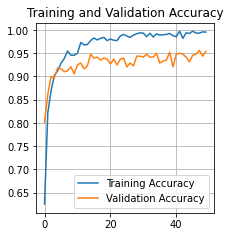

In [ ]:
# plot the trainig result
epochs_range = range(50)
plt.figure(figsize=(7, 3.5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.grid(visible=True)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [ ]:
import os,shutil
categories = ["glass","metal","cardboard","paper","plastic"]
originalPath='XueyingLi_TrashData/'
for i in range(5):
  TrashNetPath="TrashNet"+str(i)
  for className in categories:
    fileList=os.listdir(originalPath+className+"/")
    for file in fileList:
      shutil.copy(originalPath+className+"/"+file,TrashNetPath+"/"+'train'+"/"+className+"/"+file)

In [ ]:
import os
# Set variables for testing
# checkpoint weight to test
modelCheckPointName="/ckpt"
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
modelStructure = "efficientnet" #
batch_size = 16
basemodel_img_height =384
basemodel_img_width = 512
learning_rate=4.3e-5
TrainingPath=''

In [ ]:
train_ds,val_ds=loadTrainData("TrashNet0/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,5)
epochs=40
model,history=compileModel(model,learning_rate,epochs,train_ds,val_ds)

Found 2839 files belonging to 5 classes.
Using 2130 files for training.
Found 2839 files belonging to 5 classes.
Using 709 files for validation.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 384, 512, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 12, 16, 1280)     4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                

In [ ]:
testAccuracy(model,"TrashNet0/test",image_size=(384,512))

Found 478 files belonging to 5 classes.
1/1 [==============================] - 0s 25ms/step
The test accuracy is 92.25941422594143%


array([[ 75,   0,   0,   6,   0],
       [  0,  92,   3,   0,   5],
       [  1,   2,  76,   0,   3],
       [  0,   2,   0, 117,   0],
       [  1,   5,   2,   7,  81]])

Head

Date : 03/27/2022<br />
Author : Xueying Li<br />
Description : This file is used to test and evaluate the model's accuracy<br />
Reference: I used part of code from https://github.com/mazabdul7/AtTheEdge/blob/main/Training.ipynb.<br /> 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!/opt/bin/nvidia-smi

Fri Jan 13 02:01:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!pip install tensorflow==2.11

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pathlib
from tensorflow.keras import layers
import random
import sys
from sklearn.metrics import confusion_matrix
sys.path.append('/content/drive/MyDrive')
sys.path.append('/content/drive/MyDrive/year3')
%cd /content/drive/MyDrive/year3

/content/drive/MyDrive/year3


In [ ]:
print(tf.__version__) # TF Version

2.9.2


In [ ]:
tf.random.set_seed(123)

In [ ]:
# Set variables for testing
# checkpoint weight to test
import os
modelCheckPointName="/ckpt"
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
modelStructure = "mobilenetV1" # or "efficientnet"
batch_size = 16
basemodel_img_height =224
basemodel_img_width = 224
learning_rate=4.3e-5
TrainingPath=''

## **1.3**  :Compare with the 7-class **EfficientNet** using **TrashNet data+ XueyingLi dataset** 384x512 and 5-fold cross validation

In [ ]:
# Set variables for testing
# checkpoint weight to test
import os
modelCheckPointName="/ckpt"
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
modelStructure = "efficientnet" # or "efficientnet"
batch_size = 16
basemodel_img_height =384
basemodel_img_width = 512
learning_rate=4.3e-5
TrainingPath=''

### trial 1

In [ ]:
train_ds,val_ds=loadTrainData("XTrashNet0/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,7)
epochs=50
model,history=compileModel(model,learning_rate,epochs,train_ds,val_ds)

Found 3657 files belonging to 7 classes.
Using 2743 files for training.
Found 3657 files belonging to 7 classes.
Using 914 files for validation.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 384, 512, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 12, 16, 1280)     4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 7)                 8967      
                                                

In [ ]:
testAccuracy(model,"XTrashNet0/test",image_size=(384,512))

Found 683 files belonging to 7 classes.
1/1 [==============================] - 0s 23ms/step
The test accuracy is 93.70424597364568%


array([[ 78,   0,   0,   0,   0,   3,   0],
       [  0,  21,   0,   0,   0,   0,   0],
       [  0,   0,  97,   0,   3,   0,   0],
       [  4,   0,   0, 174,   2,   2,   2],
       [  0,   0,   5,   0,  77,   0,   0],
       [  2,   0,   1,   0,   0, 115,   1],
       [  0,   0,  15,   0,   1,   2,  78]])

In [ ]:
# history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(str(acc)+",")
print(str(val_acc)+",")

loss = history.history['loss']
val_loss = history.history['val_loss']
print(str(loss)+",")

print(str(val_loss)+",")

[0.6084578633308411, 0.7921983003616333, 0.8242799639701843, 0.8501640558242798, 0.8621946573257446, 0.8928180932998657, 0.9125045537948608, 0.9187021255493164, 0.9227123856544495, 0.934013843536377, 0.935836672782898, 0.9416697025299072, 0.9423988461494446, 0.9500547051429749, 0.9566168189048767, 0.9496901035308838, 0.962814450263977, 0.9500547051429749, 0.9598979353904724, 0.966460108757019, 0.9682828783988953, 0.9701057076454163, 0.9701057076454163, 0.9737513661384583, 0.9701057076454163, 0.9730222225189209, 0.9810426831245422, 0.9795843958854675, 0.9719285368919373, 0.9737513661384583, 0.9795843958854675, 0.9828654527664185, 0.9784907102584839, 0.9814072251319885, 0.9846882820129395, 0.9839591979980469, 0.9781261682510376, 0.9788552522659302, 0.9879693984985352, 0.9861465692520142, 0.9857819676399231, 0.9857819676399231, 0.9828654527664185, 0.9817717671394348, 0.9865111112594604, 0.9850528836250305, 0.9850528836250305, 0.9916149973869324, 0.9872402548789978, 0.9835945963859558],
[0

Text(0.5, 1.0, 'Training and Validation Accuracy')

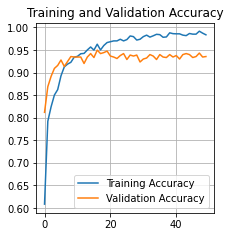

In [ ]:
# plot the trainig result
epochs_range = range(50)
plt.figure(figsize=(7, 3.5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.grid(visible=True)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

### trial 2

In [ ]:
train_ds,val_ds=loadTrainData("XTrashNet1/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,7)
epochs=50
model,history=compileModel(model,learning_rate,epochs,train_ds,val_ds)

Found 3657 files belonging to 7 classes.
Using 2743 files for training.
Found 3657 files belonging to 7 classes.
Using 914 files for validation.
16705208/16705208 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 384, 512, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 12, 16, 1280)     4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 7)           

In [ ]:
testAccuracy(model,"TrashNet1/test",image_size=(384,512))

Found 683 files belonging to 7 classes.
1/1 [==============================] - 0s 23ms/step
The test accuracy is 93.1185944363104%


array([[ 75,   0,   2,   1,   0,   2,   1],
       [  0,  21,   0,   0,   0,   0,   0],
       [  0,   0,  97,   0,   2,   0,   1],
       [  1,   0,   1, 180,   1,   0,   1],
       [  0,   0,   8,   0,  68,   1,   5],
       [  7,   0,   1,   1,   1, 107,   2],
       [  0,   0,   8,   0,   0,   0,  88]])

### trial 3

In [ ]:
train_ds,val_ds=loadTrainData("XTrashNet2/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,7)
epochs=50
model,history=compileModel(model,learning_rate,epochs,train_ds,val_ds)

Found 3657 files belonging to 7 classes.
Using 2743 files for training.
Found 3657 files belonging to 7 classes.
Using 914 files for validation.
16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 384, 512, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 12, 16, 1280)     4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 7)           

In [ ]:
testAccuracy(model,"XTrashNet2/test",image_size=(384,512))

Found 683 files belonging to 7 classes.
1/1 [==============================] - 0s 25ms/step
The test accuracy is 95.46120058565154%


array([[ 80,   0,   0,   0,   0,   1,   0],
       [  0,  21,   0,   0,   0,   0,   0],
       [  0,   0,  90,   0,   2,   0,   8],
       [  0,   0,   2, 177,   1,   2,   2],
       [  0,   0,   2,   0,  79,   0,   1],
       [  5,   0,   0,   0,   1, 111,   2],
       [  0,   0,   0,   0,   1,   1,  94]])

### trial 4

In [ ]:
train_ds,val_ds=loadTrainData("XTrashNet3/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,7)
epochs=50
model,history=compileModel(model,learning_rate,epochs,train_ds,val_ds)

Found 3657 files belonging to 7 classes.
Using 2743 files for training.
Found 3657 files belonging to 7 classes.
Using 914 files for validation.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 384, 512, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 12, 16, 1280)     4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 7)                 8967      
                                              

In [ ]:
testAccuracy(model,"XTrashNet3/test",image_size=(384,512))

Found 683 files belonging to 7 classes.
1/1 [==============================] - 0s 26ms/step
The test accuracy is 95.46120058565154%


array([[ 75,   0,   1,   0,   0,   5,   0],
       [  1,  20,   0,   0,   0,   0,   0],
       [  0,   0,  97,   0,   2,   0,   1],
       [  2,   0,   0, 178,   1,   2,   1],
       [  0,   0,   5,   0,  77,   0,   0],
       [  2,   0,   0,   0,   0, 117,   0],
       [  0,   0,   6,   0,   2,   0,  88]])

In [ ]:
from google. colab import runtime 
runtime.unassign() 

### trial 5

In [ ]:
train_ds,val_ds=loadTrainData("XTrashNet4/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,7)
epochs=50
model,history=compileModel(model,learning_rate,epochs,train_ds,val_ds)

Found 3662 files belonging to 7 classes.
Using 2747 files for training.
Found 3662 files belonging to 7 classes.
Using 915 files for validation.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 384, 512, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 12, 16, 1280)     4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 7)                 8967      
                                              

In [ ]:
testAccuracy(model,"XTrashNet4/test",image_size=(384,512))

Found 678 files belonging to 7 classes.
1/1 [==============================] - 0s 24ms/step
The test accuracy is 93.65781710914455%


array([[ 76,   0,   0,   0,   0,   1,   2],
       [  0,  20,   0,   0,   0,   0,   0],
       [  0,   0,  93,   0,   3,   0,   4],
       [  2,   0,   1, 175,   2,   2,   1],
       [  0,   0,   2,   0,  77,   0,   3],
       [  7,   0,   1,   0,   1, 108,   1],
       [  1,   0,   5,   0,   4,   0,  86]])

### trial0


In [ ]:
import math
train_ds,val_ds=loadTrainData("XTrashNet0/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,7)

epochs=50
model,history=compileModel(model,4.3e-5,epochs,train_ds,val_ds)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


Found 3657 files belonging to 7 classes.
Using 2743 files for training.
Found 3657 files belonging to 7 classes.
Using 914 files for validation.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 384, 512, 3)       7         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 mobilenet_0.75_224 (Functio  (None, 7, 7, 768)        1832976   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 768)              0         
 (GlobalAveragePooling2D)                     

172/172 [==============================] - 33s 167ms/step - loss: 1.6448 - accuracy: 0.3719 - val_loss: 1.5108 - val_accuracy: 0.4158
Epoch 2/50
172/172 [==============================] - 24s 139ms/step - loss: 1.4044 - accuracy: 0.4674 - val_loss: 1.3671 - val_accuracy: 0.4891
Epoch 3/50
172/172 [==============================] - 24s 140ms/step - loss: 1.3158 - accuracy: 0.4976 - val_loss: 1.3397 - val_accuracy: 0.5066
Epoch 4/50
172/172 [==============================] - 25s 143ms/step - loss: 1.2250 - accuracy: 0.5345 - val_loss: 1.1852 - val_accuracy: 0.5569
Epoch 5/50
172/172 [==============================] - 25s 144ms/step - loss: 1.1776 - accuracy: 0.5618 - val_loss: 1.0812 - val_accuracy: 0.6094
Epoch 6/50
172/172 [==============================] - 24s 142ms/step - loss: 1.1482 - accuracy: 0.5716 - val_loss: 1.2015 - val_accuracy: 0.5449
Epoch 7/50
172/172 [==============================] - 25s 143ms/step - loss: 1.1187 - accuracy: 0.5815 - val_loss: 1.0953 - val_accuracy: 0.5

In [ ]:

print(str(acc)+",")
print(str(val_acc)+",")
print(str(loss)+",")

print(str(val_loss)+",")

[0.5308057069778442, 0.7342326045036316, 0.7998541593551636, 0.8268319368362427, 0.8512577414512634, 0.8672986030578613, 0.8742253184318542, 0.900473952293396, 0.9019321799278259, 0.9055778384208679, 0.923441469669342, 0.9281808137893677, 0.9263579845428467, 0.9383886456489563, 0.9413051605224609, 0.9420342445373535, 0.9478672742843628, 0.9449507594108582, 0.9537003040313721, 0.9595333337783813, 0.9588042497634888, 0.9591687917709351, 0.9566168189048767, 0.9551585912704468, 0.964637279510498, 0.9598979353904724, 0.967918336391449, 0.9682828783988953, 0.9668246507644653, 0.9704703092575073, 0.9682828783988953, 0.9690120220184326, 0.971563994884491, 0.9722931385040283, 0.9810426831245422, 0.96974116563797, 0.975209653377533, 0.9730222225189209, 0.9744805097579956, 0.9704703092575073, 0.9770324230194092, 0.9814072251319885, 0.9832300543785095, 0.9832300543785095, 0.9777615666389465, 0.9821363687515259, 0.9835945963859558, 0.9759387373924255, 0.9821363687515259, 0.9879693984985352],
[0.731

In [ ]:
testAccuracy(model,"XTrashNet0/test",image_size=(384,512))

Found 683 files belonging to 7 classes.
1/1 [==============================] - 0s 23ms/step
The test accuracy is 93.41142020497803%


array([[ 75,   0,   0,   0,   1,   5,   0],
       [  1,  20,   0,   0,   0,   0,   0],
       [  0,   0,  92,   0,   3,   1,   4],
       [  4,   0,   2, 173,   2,   3,   0],
       [  0,   0,   2,   0,  80,   0,   0],
       [  1,   0,   0,   0,   8, 110,   0],
       [  0,   0,   0,   0,   6,   2,  88]])

### trial1


In [ ]:
import math
train_ds,val_ds=loadTrainData("XTrashNet1/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,7)

epochs=50
model,history=compileModel(model,4.3e-5,epochs,train_ds,val_ds)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


Found 3657 files belonging to 7 classes.
Using 2743 files for training.
Found 3657 files belonging to 7 classes.
Using 914 files for validation.
10626956/10626956 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 mobilenet_0.75_224 (Functio  (None, 7, 7, 768)        1832976   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 768)              0         
 lobalAveragePooling2D)                                          
                                                 

In [ ]:

print(str(acc)+",")
print(str(val_acc)+",")
print(str(loss)+",")

print(str(val_loss)+",")

[0.5308057069778442, 0.7342326045036316, 0.7998541593551636, 0.8268319368362427, 0.8512577414512634, 0.8672986030578613, 0.8742253184318542, 0.900473952293396, 0.9019321799278259, 0.9055778384208679, 0.923441469669342, 0.9281808137893677, 0.9263579845428467, 0.9383886456489563, 0.9413051605224609, 0.9420342445373535, 0.9478672742843628, 0.9449507594108582, 0.9537003040313721, 0.9595333337783813, 0.9588042497634888, 0.9591687917709351, 0.9566168189048767, 0.9551585912704468, 0.964637279510498, 0.9598979353904724, 0.967918336391449, 0.9682828783988953, 0.9668246507644653, 0.9704703092575073, 0.9682828783988953, 0.9690120220184326, 0.971563994884491, 0.9722931385040283, 0.9810426831245422, 0.96974116563797, 0.975209653377533, 0.9730222225189209, 0.9744805097579956, 0.9704703092575073, 0.9770324230194092, 0.9814072251319885, 0.9832300543785095, 0.9832300543785095, 0.9777615666389465, 0.9821363687515259, 0.9835945963859558, 0.9759387373924255, 0.9821363687515259, 0.9879693984985352],
[0.731

In [ ]:
testAccuracy(model,"XTrashNet0/test",image_size=(384,512))

Found 683 files belonging to 7 classes.
1/1 [==============================] - 0s 23ms/step
The test accuracy is 93.41142020497803%


array([[ 75,   0,   0,   0,   1,   5,   0],
       [  1,  20,   0,   0,   0,   0,   0],
       [  0,   0,  92,   0,   3,   1,   4],
       [  4,   0,   2, 173,   2,   3,   0],
       [  0,   0,   2,   0,  80,   0,   0],
       [  1,   0,   0,   0,   8, 110,   0],
       [  0,   0,   0,   0,   6,   2,  88]])

In [ ]:
train_ds,val_ds=loadTrainData("TrashNet0/train",size=(384,512))
model=createModel(modelStructure,basemodel_img_height,basemodel_img_width,batch_size,5)
epochs=20
model,history=compileModel(model,learning_rate,epochs,train_ds,val_ds)
testAccuracy(model,"TrashNet0/test",image_size=(384,512))

Found 1912 files belonging to 5 classes.
Using 1434 files for training.
Found 1912 files belonging to 5 classes.
Using 478 files for validation.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 384, 512, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 12, 16, 1280)     4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                

In [ ]:
# Set variables for testing
# checkpoint weight to test
modelCheckPointName="/ckpt"
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
modelStructure = "efficientnet" #
batch_size = 16
basemodel_img_height =384
basemodel_img_width = 512
learning_rate=4.3e-5
TrainingPath=''

In [ ]:
# Set variables for testing
# checkpoint weight to test
modelCheckPointName="/ckpt"
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
modelStructure = "mobilenet" # or "efficientnet"
batch_size = 16
basemodel_img_height =384
basemodel_img_width = 512
learning_rate=4.3e-5
TrainingPath=''

Test the model

In [ ]:
# Create the confusion matrix plot
def cmplot(correctLabel,predictedLabel,labels,titleName):
    confusionmatrix = confusion_matrix(correctLabel,predictedLabel)
    cm= []
    cm = confusionmatrix/confusionmatrix.sum(axis=0)
    print(cm)
    cm=np.mean(cm.diagonal())
    print(cm)
    # Make the confusion matrix plot
    fig, axes = plt.subplots()
    axes.imshow(confusionmatrix, cmap = plt.cm.GnBu,interpolation='nearest')
    axes.set_title(titleName)
    n = np.array(range(len(labels)))
    axes.set_yticks(n)
    axes.set_yticklabels(labels)
    axes.set_xticks(n)
    axes.set_xticklabels(labels, rotation=45)
    threshold = confusionmatrix.max() / 2. 
    for i in range(len(confusionmatrix)):
        for j in range(len(confusionmatrix[0])):
            axes.text(j, i, format(confusionmatrix[i, j], 'd'),horizontalalignment = 'center', 
                                   color = 'white' if confusionmatrix[i, j] > threshold else "black")
        axes.set_ylabel('True label')
        axes.set_xlabel('Predicted label')

In [ ]:
def displayWrongImage(wrongImage):
    for i in wrongImage:
        plt.figure(figsize=(5,5))
        plt.imshow(((1-i[0][0])*255).astype('uint8'))
        plt.show()

In [ ]:

# Test accuracy on original TrashNet testset 
[wrongImage,model]=testAccuracy("xueyingsplitall/testorigin","Confusion matrix (TrashNet test)",label= ["cardboard", "glass","metal", "paper", "plastic"])
# Test accuracy on TrashNet testset + New hand & empty testset
#[wrongImage,model]=testAccuracy("xueyingsplitall/test","Confusion matrix (Mixed test)",label=["cardboard", "empty","glass","hand" ,"metal", "paper", "plastic"])



In [ ]:
print(wrongImage)

In [ ]:
def savemodelh5(model,name="model.h5"):
    model.save(name,include_optimizer=False)
def savemodelpb(model,name="model"):
    model.save(name,include_optimizer=False)
savemodelh5(model,name="best224.h5")

## **Appendix**

In [ ]:
import os, random
import shutil
# with the old data. It copies data from new data path to all data path
allDataPath = "top/"
# The data used for training contains 7 folders, including 5 waste+hand+empty
# The data collected by Jetson nano contains two folders: top and side, and each folder also has the 7 categories
# The code copy the data collected by Jetson nano to the folder of the data used for training
categories = ["glass","metal","cardboard","paper","plastic","hand","empty"]

for c in categories:
    fileList =os.listdir(allDataPath+c+"/")
    
    for i,file in enumerate(fileList):
      os.rename(allDataPath+c+"/"+file,allDataPath+c+"/"+"XL_"+c+"_"+str(i)+".jpg")

In [ ]:
import csv
import tensorflow as tf
import os, random
import shutil
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import math

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow import keras

from sklearn.metrics import confusion_matrix

# read the labels of the cartoon train and test file

# old cartoon data oth
def cmplot(cm,labels,titleName):
    if len(labels)==5:
      fonts=13
    else: 
      fonts=12

    confusionmatrix=cm
    confusionmatrix=confusionmatrix/confusionmatrix.sum(axis=1, keepdims=True)
    # Make the confusion matrix plot
    fig, axes = plt.subplots()
    axes.imshow(confusionmatrix, cmap = plt.cm.GnBu,interpolation='nearest')
    axes.set_title(titleName,fontsize=fonts+3)
    n = np.array(range(len(labels)))
    axes.set_yticks(n)
    axes.set_yticklabels(labels,fontsize=14)
    axes.set_xticks(n)
    axes.set_xticklabels(labels, rotation=45,fontsize=14)
    threshold = confusionmatrix.max() / 2. 
    for i in range(len(confusionmatrix)):
        for j in range(len(confusionmatrix[0])):
            axes.text(j, i, "{:.1f}".format(confusionmatrix[i, j]*100),horizontalalignment = 'center', fontsize=fonts,
                                   color = 'white' if confusionmatrix[i, j] > threshold else "black")
        axes.set_ylabel('True label',fontsize=14)
        axes.set_xlabel('Predicted label',fontsize=14)
cm1=np.array([[ 78, 0, 0, 0, 0, 3, 0], [ 0, 21, 0, 0, 0, 0, 0], [ 0, 0, 97, 0, 3, 0, 0], [ 4, 0, 0, 174, 2, 2, 2], [ 0, 0, 5, 0, 77, 0, 0], [ 2, 0, 1, 0, 0, 115, 1], [ 0, 0, 15, 0, 1, 2, 78]])

[[384   0   3   1   0  12   3]
 [  1 103   0   0   0   0   0]
 [  0   0 474   0  12   0  14]
 [  9   0   4 884   7   8   7]
 [  0   0  22   0 378   1   9]
 [ 23   0   3   1   3 558   6]
 [  1   0  34   0   8   3 434]]
[403 104 500 919 410 594 480]


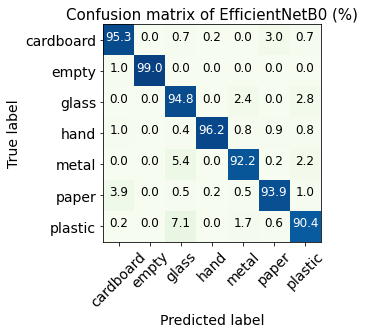

In [ ]:
cm1=np.array([[ 78, 0, 0, 0, 0, 3, 0], [ 0, 21, 0, 0, 0, 0, 0], [ 0, 0, 97, 0, 3, 0, 0], [ 4, 0, 0, 174, 2, 2, 2], [ 0, 0, 5, 0, 77, 0, 0], [ 2, 0, 1, 0, 0, 115, 1], [ 0, 0, 15, 0, 1, 2, 78]])
cm2=np.array([[ 75, 0, 2, 1, 0, 2, 1], [ 0, 21, 0, 0, 0, 0, 0], [ 0, 0, 97, 0, 2, 0, 1], [ 1, 0, 1, 180, 1, 0, 1], [ 0, 0, 8, 0, 68, 1, 5], [ 7, 0, 1, 1, 1, 107, 2], [ 0, 0, 8, 0, 0, 0, 88]])
cm3=np.array([[ 80, 0, 0, 0, 0, 1, 0], [ 0, 21, 0, 0, 0, 0, 0], [ 0, 0, 90, 0, 2, 0, 8], [ 0, 0, 2, 177, 1, 2, 2], [ 0, 0, 2, 0, 79, 0, 1], [ 5, 0, 0, 0, 1, 111, 2], [ 0, 0, 0, 0, 1, 1, 94]])
cm4=np.array([[ 75, 0, 1, 0, 0, 5, 0], [ 1, 20, 0, 0, 0, 0, 0], [ 0, 0, 97, 0, 2, 0, 1], [ 2, 0, 0, 178, 1, 2, 1], [ 0, 0, 5, 0, 77, 0, 0], [ 2, 0, 0, 0, 0, 117, 0], [ 0, 0, 6, 0, 2, 0, 88]])
cm5=np.array([[ 76, 0, 0, 0, 0, 1, 2], [ 0, 20, 0, 0, 0, 0, 0], [ 0, 0, 93, 0, 3, 0, 4], [ 2, 0, 1, 175, 2, 2, 1], [ 0, 0, 2, 0, 77, 0, 3], [ 7, 0, 1, 0, 1, 108, 1], [ 1, 0, 5, 0, 4, 0, 86]])

cm=cm1+cm2+cm3+cm4+cm5
print(cm)
confusionmatrix=cm.sum(axis=1)
print(confusionmatrix)
cmplot(cm,["cardboard", "empty","glass","hand","metal", "paper", "plastic"],"Confusion matrix of EfficientNetB0 (%)")

In [ ]:
np.array([[8,8],[4,4
]])/np.array([2,1])

array([[4., 8.],
       [2., 4.]])

In [ ]:
"{:.1f}".format(1/104*100)

'1.0'

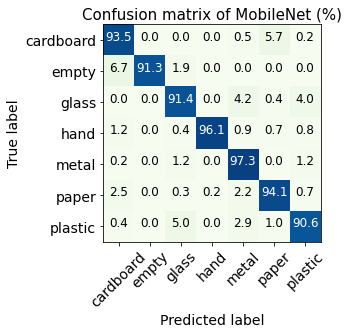

In [ ]:
cm1=np.array([[ 76, 0, 0, 0, 1, 4, 0], [ 0, 21, 0, 0, 0, 0, 0], [ 0, 0, 91, 0, 4, 0, 5], [ 4, 0, 2, 174, 1, 2, 1], [ 0, 0, 2, 0, 79, 0, 1], [ 0, 0, 0, 1, 5, 113, 0], [ 0, 0, 4, 0, 2, 2, 88]])
cm2=np.array([[ 75, 0, 0, 0, 1, 5, 0], [ 1, 18, 2, 0, 0, 0, 0], [ 0, 0, 93, 0, 5, 1, 1], [ 1, 0, 0, 179, 1, 1, 2], [ 0, 0, 1, 0, 81, 0, 0], [ 5, 0, 1, 0, 1, 112, 0], [ 0, 0, 6, 0, 2, 1, 87]])
cm3=np.array([[ 76, 0, 0, 0, 0, 5, 0], [ 4, 17, 0, 0, 0, 0, 0], [ 0, 0, 95, 0, 4, 1, 0], [ 1, 0, 0, 181, 0, 2, 0], [ 0, 0, 1, 0, 81, 0, 0], [ 6, 0, 1, 0, 3, 107, 2], [ 1, 0, 5, 0, 4, 2, 84]])
cm4=np.array([[ 77, 0, 0, 0, 0, 1, 1], [ 1, 19, 0, 0, 0, 0, 0], [ 0, 0, 84, 0, 7, 0, 9], [ 4, 0, 1, 173, 3, 1, 1], [ 0, 0, 1, 0, 78, 0, 3], [ 2, 0, 0, 0, 4, 110, 2], [ 1, 0, 6, 0, 2, 0, 87]])
cm5=np.array([[ 73, 0, 0, 0, 0, 8, 0], [ 1, 20, 0, 0, 0, 0, 0], [ 0, 0, 94, 0, 1, 0, 5], [ 1, 0, 1, 176, 3, 0, 3], [ 1, 0, 0, 0, 80, 0, 1], [ 2, 0, 0, 0, 0, 117, 0], [ 0, 0, 3, 0, 4, 0, 89]])

cm=cm1+cm2+cm3+cm4+cm5
cmplot(cm,["cardboard", "empty","glass","hand","metal", "paper", "plastic"],"Confusion matrix of MobileNet (%)")

[[ 74   0   0   0   7   0]
 [  0  89   0   3   1   7]
 [  4   0 178   1   0   1]
 [  0   1   0  80   1   0]
 [  0   0   0   0 118   1]
 [  0   2   0   4   1  86]]
0.9410526315789474
[[ 75   0   0   1   5   0]
 [  0  90   0   6   0   4]
 [  3   0 179   1   0   1]
 [  0   1   0  79   1   1]
 [  2   1   0   1 114   1]
 [  0   3   0   0   1  89]]
0.9410526315789474
[[ 79   0   0   0   2   0]
 [  0  93   0   3   2   2]
 [  4   0 177   2   1   0]
 [  0   2   0  80   0   0]
 [  3   0   0   1 114   1]
 [  0   3   0   1   4  85]]
0.9494736842105264
[[ 75   0   0   0   6   0]
 [  0  96   0   3   0   1]
 [  6   0 169   5   1   3]
 [  1   0   0  81   0   0]
 [  2   0   0   0 117   0]
 [  0   2   0   1   0  90]]
0.9663157894736842
[[ 74   1   0   0   3   1]
 [  0  90   0   7   1   2]
 [  6   0 171   3   1   3]
 [  0   1   0  80   1   0]
 [  2   1   0   4 110   1]
 [  0   4   0   4   2  83]]
0.9258474576271186
0.9447484388938447


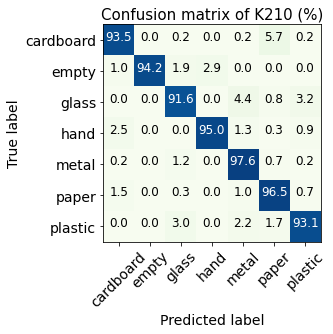

In [ ]:
cm1=np.array([[ 74, 0, 0, 0, 0, 7, 0], [ 0, 21, 0, 0, 0, 0, 0], [ 0, 0, 89, 0, 3, 1, 7], [ 4, 0, 0, 178, 1, 0, 1], [ 0, 0, 1, 0, 80, 1, 0], [ 0, 0, 0, 0, 0, 118, 1], [ 0, 0, 2, 0, 4, 1, 86]])
cm2=np.array([[ 75, 0, 0, 0, 1, 5, 0], [ 1, 18, 2, 0, 0, 0, 0], [ 0, 0, 90, 0, 6, 0, 4], [ 3, 0, 0, 179, 1, 0, 1], [ 0, 0, 1, 0, 79, 1,1], [ 2, 0, 1, 0, 1, 114,1], [ 0, 0, 3, 0, 0, 1, 89]])
cm3=np.array([[ 79, 0, 0, 0, 0, 2, 0], [ 0,20, 0,1, 0, 0, 0], [ 0, 0, 93, 0, 3, 2,2], [ 4,0, 0, 177, 2,1, 0], [ 0, 0, 2, 0, 80, 0, 0], [ 3, 0, 0, 0, 1, 114, 1], [ 0, 0, 3, 0, 1,4, 85]])
cm4=np.array([[ 75, 0, 0, 0, 0, 6, 0], [0, 21, 0, 0, 0, 0, 0], [ 0, 0, 96, 0, 3, 0, 1], [ 6, 0, 0, 169, 5, 1, 3], [ 1, 0, 0, 0, 81, 0, 0], [ 2, 0, 0, 0, 0, 117, 0], [ 0, 0, 2, 0, 1, 0, 90]])
cm5=np.array([[ 74, 0, 1, 0, 0, 3, 1], [ 0, 18, 0, 2, 0, 0, 0], [ 0, 0, 90, 0, 7, 1, 2], [ 6, 0, 0, 171, 3, 1, 3], [ 0, 0, 1, 0, 80, 1, 0], [ 2, 0, 1, 0, 4, 110, 1], [ 0, 0, 4, 0, 4, 2, 83]])
acc=[]
for cm in [cm1,cm2,cm3,cm4,cm5]:
  cm= np.delete(cm, (1), axis=0)
  cm= np.delete(cm, (1), axis=1)
  print(cm)
  cm= np.delete(cm, (2), axis=0)
  cm= np.delete(cm, (2), axis=1)
  a=cm.diagonal().sum()/cm.sum()
  acc.append(a)
  print(a)
print(sum(acc)/len(acc))
cm=cm1+cm2+cm3+cm4+cm5
cmplot(cm,["cardboard", "empty","glass","hand","metal", "paper", "plastic"],"Confusion matrix of K210 (%)")

In [ ]:
cm4=np.array()

In [ ]:
import os, random
import shutil,math

dataPath = "dataset-resized/"

dataseplit=0.2
categories = ["glass","metal","cardboard","paper","plastic"]
# Seperate 15% of the images from each category randomly to form the test set
def makeNewTestData():
    dataList=[]# categori,name,splitNo
    for c in categories:
        oldpathT = dataPath+c+"/"
        # find the total number of data in the path
        fileListT=os.listdir(oldpathT)
        numberofdata=len(fileListT)
        print(numberofdata)
        order=list(range(numberofdata))
        random.shuffle(order)
        print(order)
        numberOneSplit=round(dataseplit*numberofdata)
        for count,i in enumerate(order):
          dataList.append([c,fileListT[i],count//numberOneSplit])
    return dataList
dataList= makeNewTestData()

501
[227, 288, 349, 100, 127, 135, 326, 3, 155, 437, 223, 13, 483, 216, 269, 316, 422, 239, 231, 45, 148, 352, 433, 213, 493, 178, 482, 247, 392, 130, 110, 166, 346, 75, 487, 212, 83, 187, 168, 106, 162, 418, 93, 81, 139, 197, 304, 388, 315, 470, 452, 462, 453, 438, 117, 42, 408, 347, 6, 463, 46, 414, 238, 147, 145, 461, 358, 460, 191, 36, 109, 236, 370, 161, 456, 257, 5, 234, 156, 325, 15, 500, 186, 73, 464, 379, 79, 173, 387, 279, 69, 104, 218, 479, 406, 129, 426, 386, 277, 87, 273, 242, 423, 432, 89, 258, 371, 447, 445, 448, 146, 366, 328, 351, 204, 467, 30, 449, 270, 29, 65, 120, 324, 322, 52, 34, 248, 180, 481, 417, 1, 293, 92, 329, 411, 48, 472, 96, 421, 440, 296, 294, 314, 430, 419, 99, 209, 373, 335, 18, 469, 268, 255, 486, 189, 208, 305, 368, 185, 402, 220, 134, 74, 259, 338, 434, 355, 489, 261, 441, 331, 308, 401, 490, 403, 361, 105, 494, 385, 149, 50, 20, 241, 23, 394, 169, 71, 28, 194, 272, 203, 312, 172, 33, 265, 398, 240, 282, 200, 496, 126, 395, 327, 225, 22, 249, 64, 97

'\nimport csv\nwith open(\'data.csv\', \'w\', newline=\'\') as file:\n    writer = csv.writer(file)\n    writer.writerow(["Category", "Name", "Split"])\n    for row in dataList:\n      writer.writerow(row)'

In [ ]:
import csv
with open('data.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Category", "Name", "Split"])
    for row in dataList:
      writer.writerow(row)

In [ ]:
import os, random
import shutil,math
from PIL import Image, ImageEnhance
dataPath = "XueyingLi_TrashData/"

dataseplit=0.2

def emptyImageAugmentation():
        oldpathT = dataPath+"empty/"
        # find the total number of data in the path
        fileListT=os.listdir(oldpathT)
        numberofdata=len(fileListT)
        print(numberofdata)
        for file in fileListT:
          im=Image.open(oldpathT+file)
          out=augmentation(im)
          out.save(oldpathT+"XL_empty_"+str(numberofdata)+".png")
          numberofdata+=1

def augmentation(im):
  enhancer = ImageEnhance.Brightness(im)
  factor = random.uniform(0.5, 1.5) #gives original image
  im = enhancer.enhance(factor)
  enhancer = ImageEnhance.Contrast(im)
  factor = random.uniform(0.5, 1.5) #increase contrast
  im_output = enhancer.enhance(factor)
  angle = random.uniform(0, 180)
  im = im.rotate(angle)
  size = (512,384)
  pos=random.randrange(0,100)
  box = (pos,pos,pos+412,pos+284)
  #resize image
  out = im.resize(size, box=box)
  return out

  m_output.save('original-image.png')
emptyImageAugmentation()

52


In [ ]:
import os, random
import shutil,math

dataPath = "XueyingLi_TrashData/"

dataseplit=0.2
categories = ["hand","empty"]
# Seperate 15% of the images from each category randomly to form the test set
def makeNewTestData():
    dataList=[]# categori,name,splitNo
    for c in categories:
        oldpathT = dataPath+c+"/"
        # find the total number of data in the path
        fileListT=os.listdir(oldpathT)
        numberofdata=len(fileListT)
        print(numberofdata)
        order=list(range(numberofdata))
        random.shuffle(order)
        print(order)
        numberOneSplit=round(dataseplit*numberofdata)
        for count,i in enumerate(order):
          dataList.append([c,fileListT[i],count//numberOneSplit])
    return dataList
dataList= makeNewTestData()

919
[448, 851, 682, 370, 252, 268, 415, 460, 27, 820, 880, 718, 6, 569, 883, 150, 38, 817, 115, 365, 888, 107, 438, 303, 56, 643, 637, 549, 575, 426, 92, 43, 897, 696, 784, 83, 529, 504, 32, 265, 842, 62, 131, 215, 49, 760, 376, 687, 373, 400, 247, 316, 239, 383, 634, 84, 428, 708, 860, 331, 540, 905, 334, 5, 869, 850, 861, 323, 300, 64, 68, 332, 48, 467, 317, 846, 514, 724, 100, 672, 913, 878, 822, 155, 464, 585, 621, 357, 412, 401, 601, 385, 752, 829, 369, 292, 339, 9, 582, 141, 42, 67, 145, 413, 866, 609, 674, 315, 519, 646, 283, 871, 427, 344, 610, 604, 289, 235, 489, 362, 561, 171, 783, 63, 231, 765, 902, 188, 625, 313, 325, 868, 899, 274, 681, 433, 481, 242, 347, 872, 796, 229, 598, 748, 771, 326, 570, 105, 795, 71, 187, 622, 133, 425, 452, 196, 803, 10, 396, 692, 298, 219, 166, 144, 852, 124, 210, 302, 82, 214, 264, 525, 228, 459, 408, 46, 162, 813, 199, 419, 812, 330, 759, 79, 503, 308, 494, 384, 458, 755, 635, 536, 713, 564, 436, 487, 355, 161, 476, 108, 847, 16, 828, 22, 628,

In [ ]:
print(dataList[1])

['hand', 'XL_hand_851.jpg', 0]


In [ ]:
import csv
with open('XL_hand_empty_split.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Category", "Name", "Split"])
    for row in dataList:
      writer.writerow(row)